In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Discrete
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2

class TreasureHuntEnv(Env):
    def __init__(self,max_timesteps):
        self.action_space = Discrete(4)  
        self.observation_space = Discrete(25)
        self.max_timesteps = max_timesteps
        self.cumulative_reward = 0
        self.grid_size = (5,5)
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.timestep = 0
        self.state = np.zeros(self.grid_size)
        self.treasures = [(0,3),(2, 3)] 
        self.traps = [(1, 0), (1, 3),(3,3)] 
        self.loadRewards()
        
        

    def reset(self):
        self.loadRewards()
        self.agent_pos = [0, 0]  
        self.timestep = 0
        self.cumulative_reward = 0
        self.state[tuple(self.agent_pos)] = 15
        observation = self.state.flatten()
        return self.agent_pos, observation

    def step(self, action):    
        if action == 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2:  # Down
            self.agent_pos[0] += 1
        elif action == 3:  # Left
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size[0] - 1)
        self.timestep += 1

        reward=self.addRewards()
        self.cumulative_reward += reward

        terminated = tuple(self.agent_pos) == tuple(self.goal_pos)
        if self.max_timesteps > 0: #truncating if timestep is given
            truncated = self.timestep >= self.max_timesteps
        else:
            truncated = False

        self.loadRewards()
        self.state[tuple(self.agent_pos)] = 15
        observation = self.state.flatten()

        info = {}
        return self.agent_pos, reward, terminated, truncated,observation,info

    def render(self): 
        plt.imshow(self.state)
        plt.show()
    
    def loadRewards(self):
        self.state = np.zeros(self.grid_size)
        for t in self.treasures:
            self.state[t] = 5
        for tr in self.traps:
            self.state[tr] = -5 
        self.state[tuple(self.goal_pos)] = 10

    def addRewards(self):
        if tuple(self.agent_pos) == tuple(self.goal_pos):
            reward = 100 
        elif tuple(self.agent_pos) in self.treasures:
            reward = 20 
            self.treasures.remove(tuple(self.agent_pos)) # remove the treasure once collected
        elif tuple(self.agent_pos) in self.traps:
            reward = -20
        else:
            reward = -0.5
        return reward
    
    def render(self ,plot=False):


        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)

        def plot_image(plot_pos):

            # Initially setting every object to not be plotted.
            plot_agent, plot_trap, plot_treasure, plot_goal =  False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if len(self.treasures) > 0 and any(np.array_equal(self.treasures[i], plot_pos) for i in range(len(self.treasures))):
                plot_treasure = True
            if any(np.array_equal(self.traps[i], plot_pos) for i in range(len(self.traps))):
                plot_trap = True
            if np.array_equal(plot_pos, self.goal_pos):
                plot_goal = True

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_trap, plot_treasure, plot_goal]):
                agent = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT.png'), zoom=0.28),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            # Plot for TRAP.
            elif plot_trap and \
                    all(not item for item in
                        [plot_agent, plot_treasure, plot_goal]):
                breeze = AnnotationBbox(OffsetImage(plt.imread('./images/TRAP.png'), zoom=0.28),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(breeze)

            # Plot for Treasure.
            elif plot_treasure and \
                    all(not item for item in
                        [plot_agent, plot_trap, plot_goal]):
                gold = AnnotationBbox(OffsetImage(plt.imread('./images/TREASURE.png'), zoom=0.28),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(gold)

            # Plot for Pit.
            elif plot_goal and \
                    all(not item for item in
                        [plot_agent, plot_treasure, plot_trap]):
                pit = AnnotationBbox(OffsetImage(plt.imread('./images/GOAL.png'), zoom=0.28),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(pit)

            # Plot for Agent and TREASURE.
            elif all(item for item in [plot_agent, plot_treasure]) and \
                    all(not item for item in
                        [plot_trap, plot_goal]):
                agent_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT_WITH_TREASURE.png'), zoom=0.28),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_breeze)

            # Plot for Agent and TRAP.
            elif all(item for item in [plot_agent, plot_trap]) and \
                    all(not item for item in
                        [plot_treasure, plot_goal]):
                agent_pit = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT_WITH_TRAP.png'), zoom=0.28),
                                           np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_pit)

            # Plot for Agent and GOAL.
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_treasure, plot_trap]):
                agent_stench = AnnotationBbox(OffsetImage(plt.imread('./images/AGENT_WITH_GOAL.png'), zoom=0.28),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_stench)

        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])

        plt.xticks([0, 1, 2, 3, 4, 5])
        plt.yticks([0, 1, 2, 3, 4, 5])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image


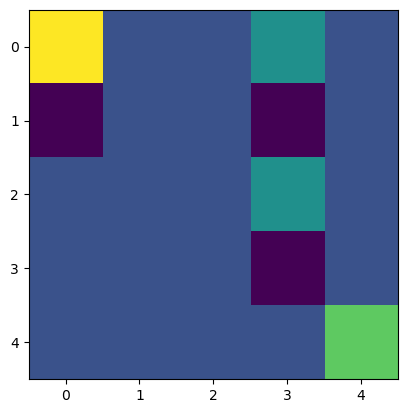

TimeStep no.: 1 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -0.5


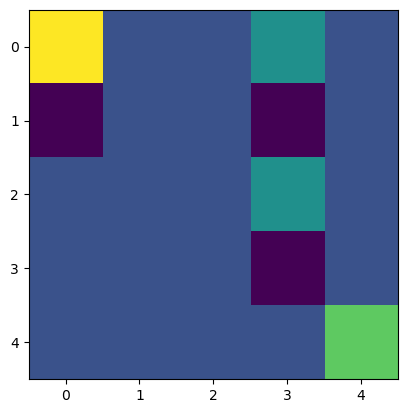

TimeStep no.: 2 , State: [0 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -1.0


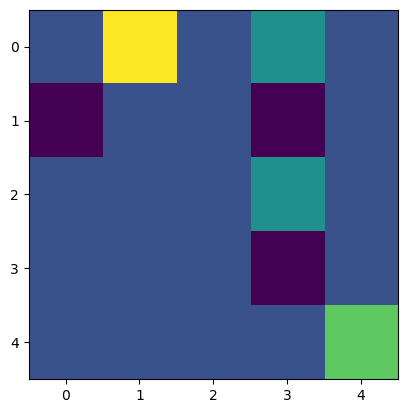

TimeStep no.: 3 , State: [1 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -1.5


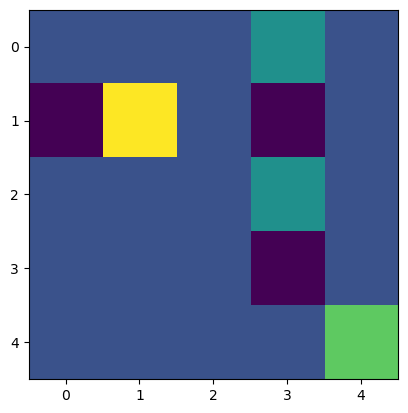

TimeStep no.: 4 , State: [2 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -2.0


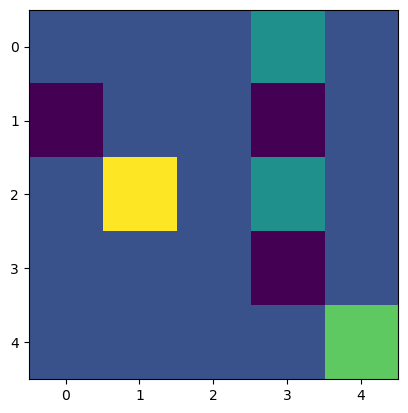

TimeStep no.: 5 , State: [2 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -2.5


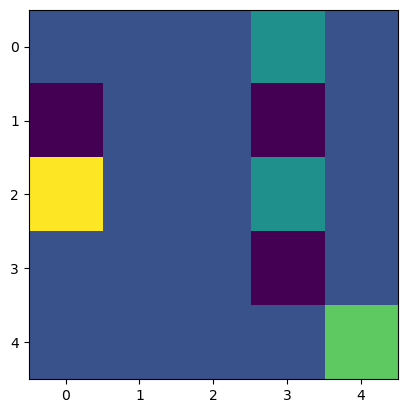

TimeStep no.: 6 , State: [3 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -3.0


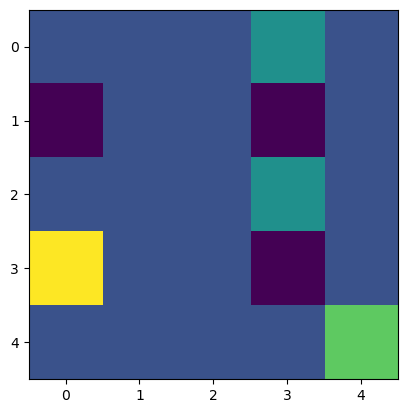

TimeStep no.: 7 , State: [4 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -3.5


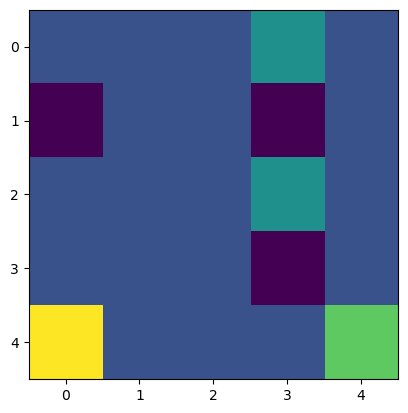

TimeStep no.: 8 , State: [3 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -4.0


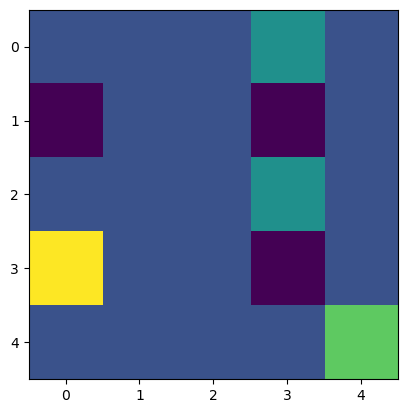

TimeStep no.: 9 , State: [2 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -4.5


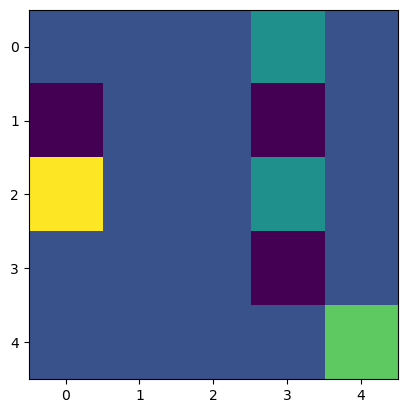

TimeStep no.: 10 , State: [2 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -5.0


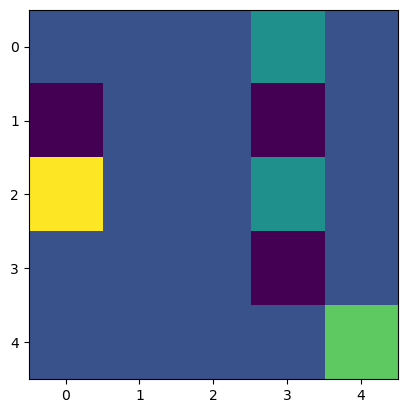

TimeStep no.: 11 , State: [2 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -5.5


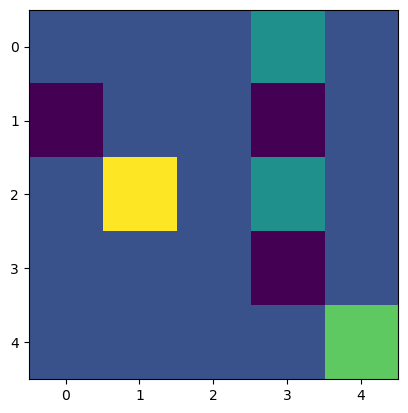

TimeStep no.: 12 , State: [2 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -6.0


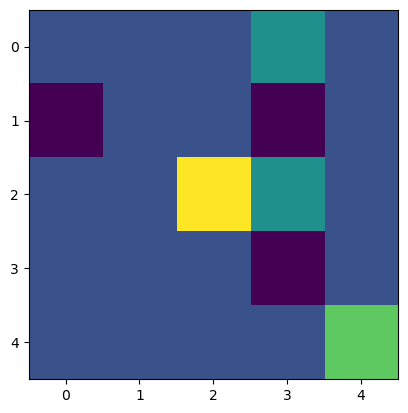

TimeStep no.: 13 , State: [2 3] , Action: 1 , Reward: 20 , Cumulative Reward: 14.0


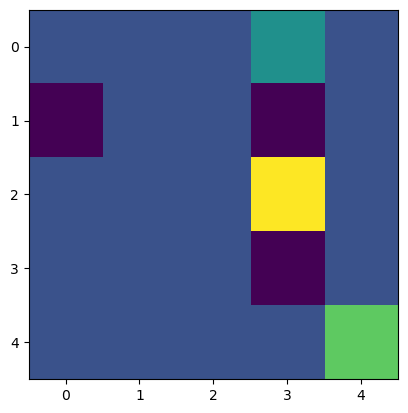

TimeStep no.: 14 , State: [1 3] , Action: 0 , Reward: -20 , Cumulative Reward: -6.0


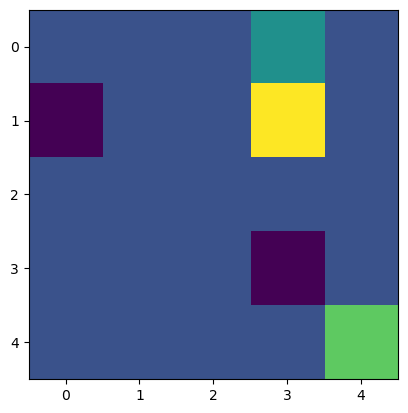

TimeStep no.: 15 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -6.5


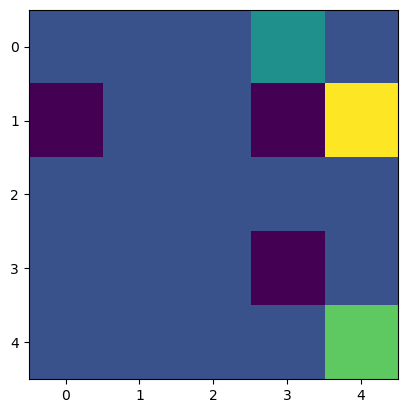

TimeStep no.: 16 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -7.0


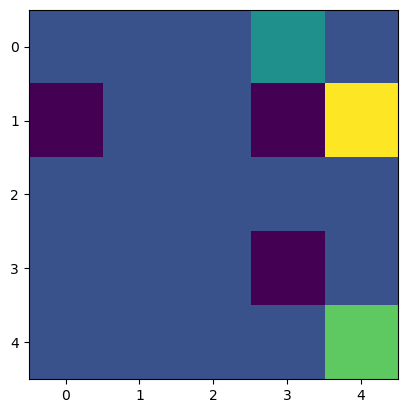

TimeStep no.: 17 , State: [2 4] , Action: 2 , Reward: -0.5 , Cumulative Reward: -7.5


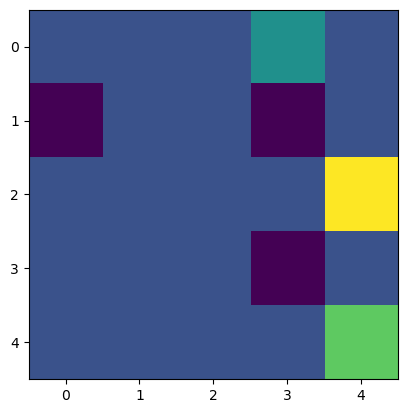

TimeStep no.: 18 , State: [1 4] , Action: 0 , Reward: -0.5 , Cumulative Reward: -8.0


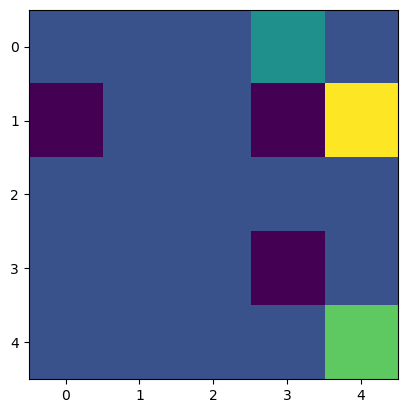

TimeStep no.: 19 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -8.5


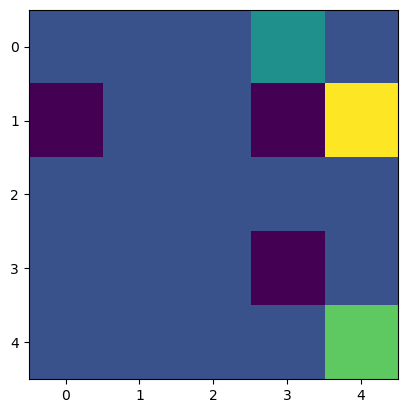

TimeStep no.: 20 , State: [0 4] , Action: 0 , Reward: -0.5 , Cumulative Reward: -9.0


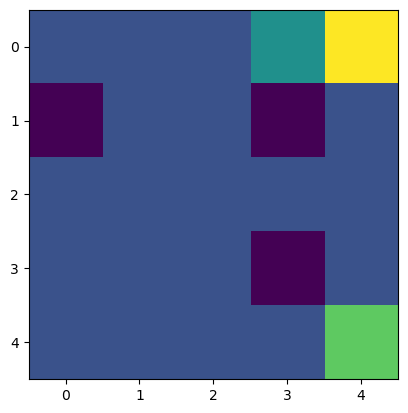

TimeStep no.: 21 , State: [0 4] , Action: 0 , Reward: -0.5 , Cumulative Reward: -9.5


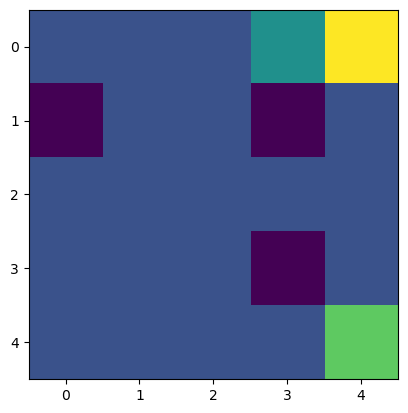

TimeStep no.: 22 , State: [0 3] , Action: 3 , Reward: 20 , Cumulative Reward: 10.5


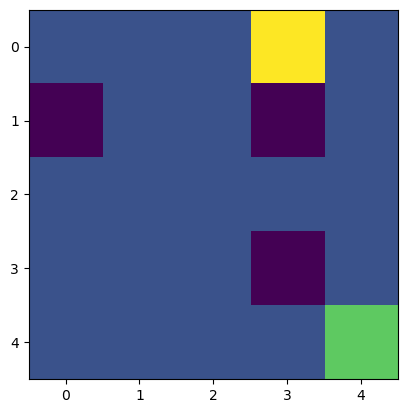

TimeStep no.: 23 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: 10.0


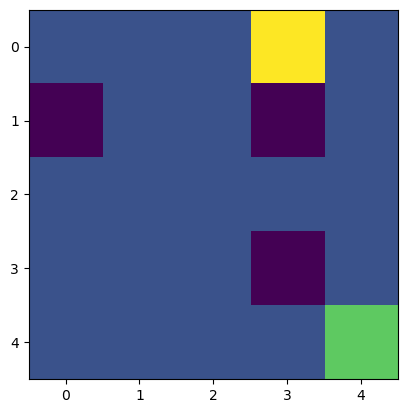

TimeStep no.: 24 , State: [0 2] , Action: 3 , Reward: -0.5 , Cumulative Reward: 9.5


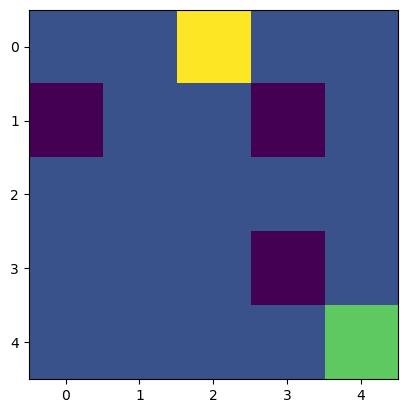

TimeStep no.: 25 , State: [1 2] , Action: 2 , Reward: -0.5 , Cumulative Reward: 9.0


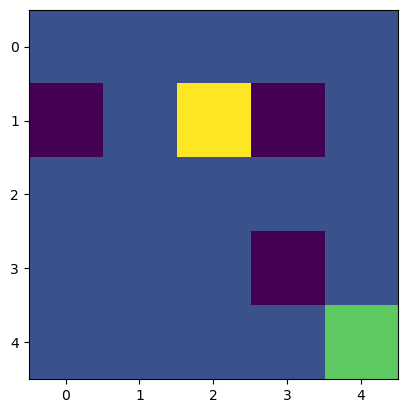

TimeStep no.: 26 , State: [0 2] , Action: 0 , Reward: -0.5 , Cumulative Reward: 8.5


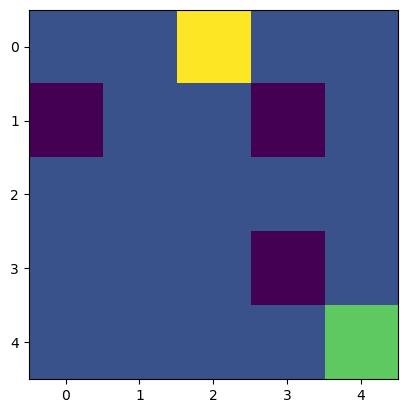

TimeStep no.: 27 , State: [0 2] , Action: 0 , Reward: -0.5 , Cumulative Reward: 8.0


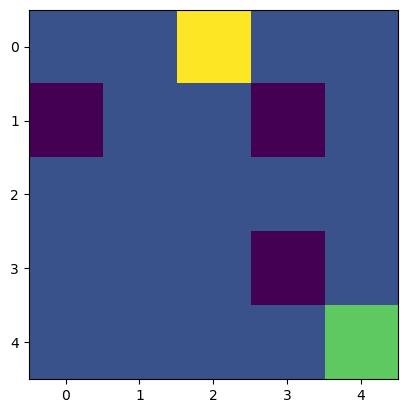

TimeStep no.: 28 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: 7.5


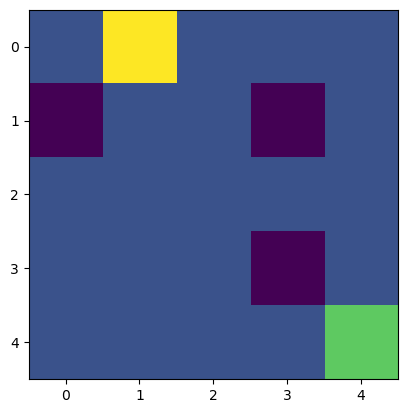

TimeStep no.: 29 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: 7.0


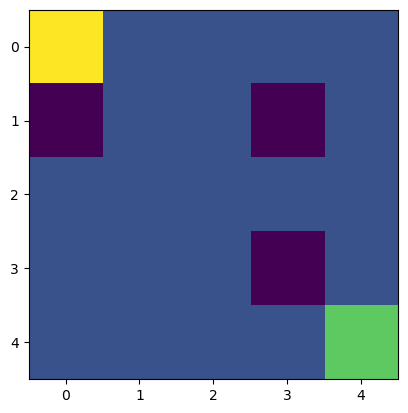

TimeStep no.: 30 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: 6.5


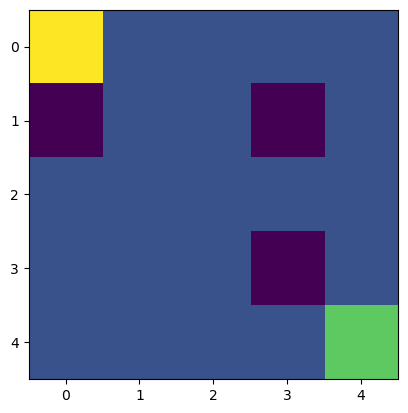

TimeStep no.: 31 , State: [1 0] , Action: 2 , Reward: -20 , Cumulative Reward: -13.5


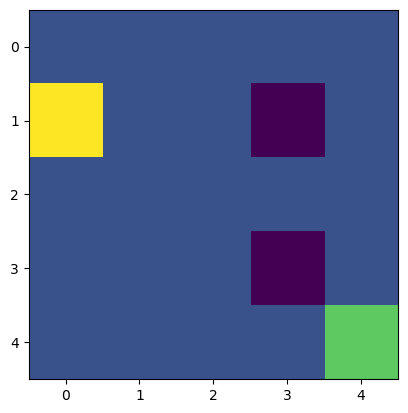

TimeStep no.: 32 , State: [1 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -14.0


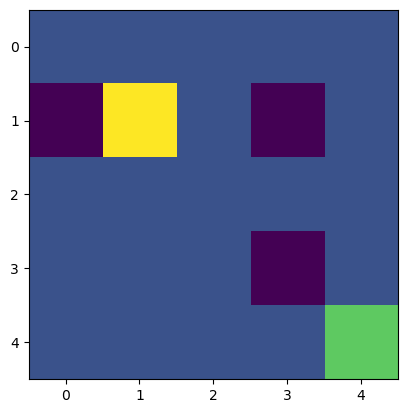

TimeStep no.: 33 , State: [2 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -14.5


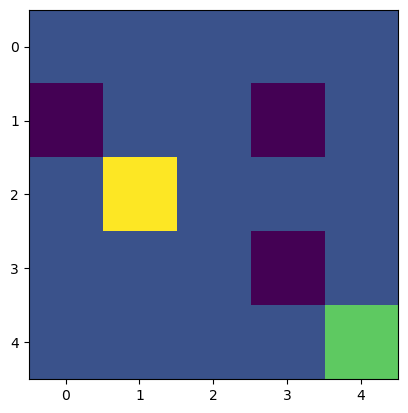

TimeStep no.: 34 , State: [1 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -15.0


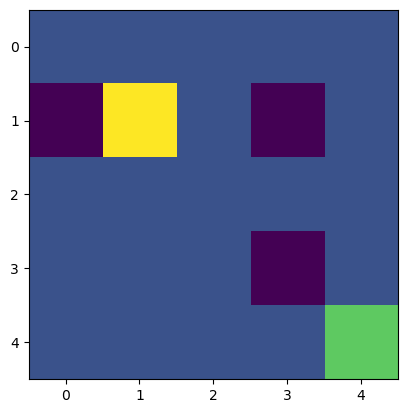

TimeStep no.: 35 , State: [1 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -15.5


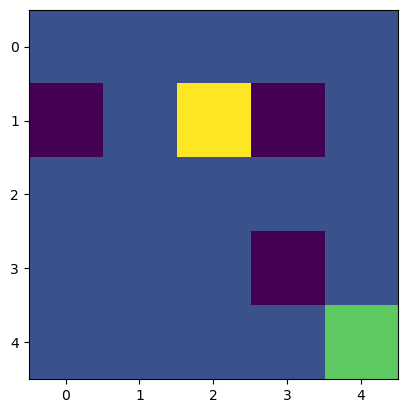

TimeStep no.: 36 , State: [1 3] , Action: 1 , Reward: -20 , Cumulative Reward: -35.5


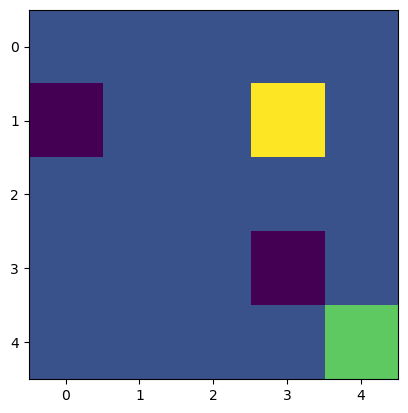

TimeStep no.: 37 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -36.0


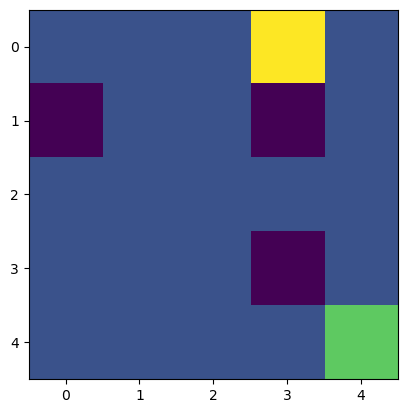

TimeStep no.: 38 , State: [1 3] , Action: 2 , Reward: -20 , Cumulative Reward: -56.0


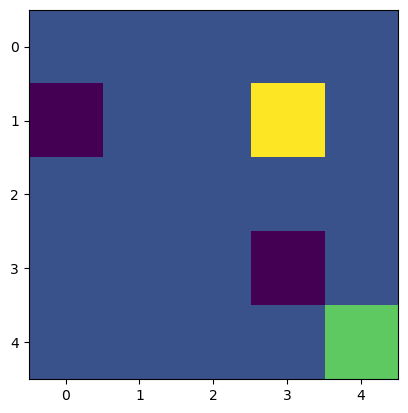

TimeStep no.: 39 , State: [1 2] , Action: 3 , Reward: -0.5 , Cumulative Reward: -56.5


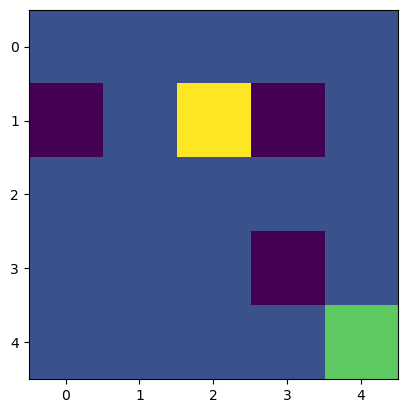

TimeStep no.: 40 , State: [1 3] , Action: 1 , Reward: -20 , Cumulative Reward: -76.5


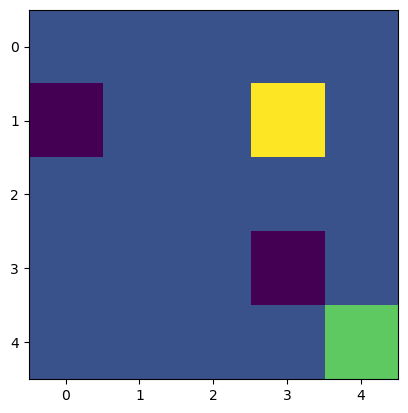

TimeStep no.: 41 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -77.0


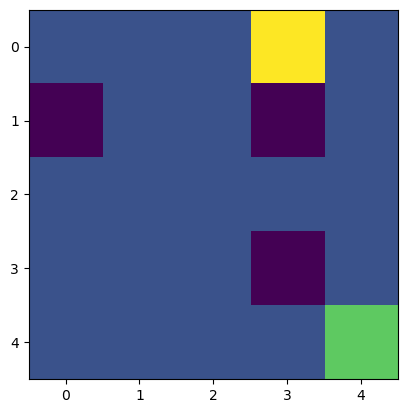

TimeStep no.: 42 , State: [1 3] , Action: 2 , Reward: -20 , Cumulative Reward: -97.0


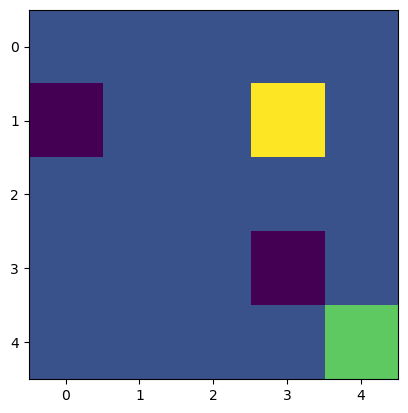

TimeStep no.: 43 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -97.5


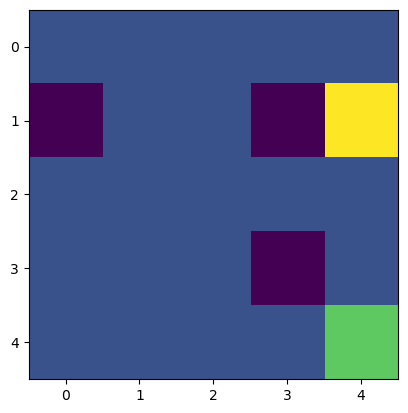

TimeStep no.: 44 , State: [1 3] , Action: 3 , Reward: -20 , Cumulative Reward: -117.5


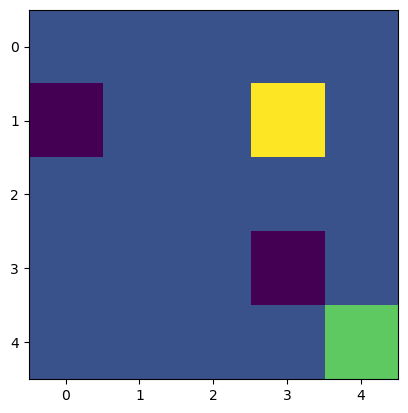

TimeStep no.: 45 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -118.0


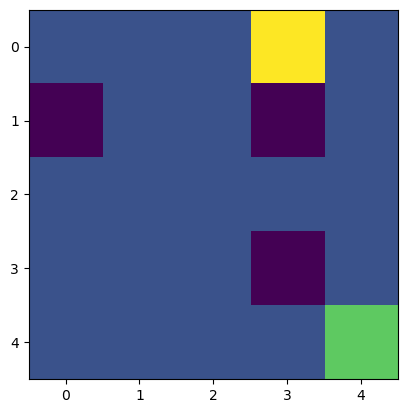

TimeStep no.: 46 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -118.5


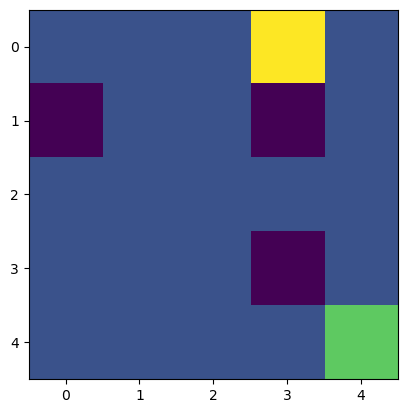

TimeStep no.: 47 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -119.0


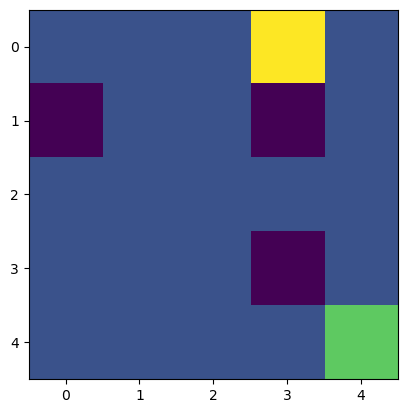

TimeStep no.: 48 , State: [0 2] , Action: 3 , Reward: -0.5 , Cumulative Reward: -119.5


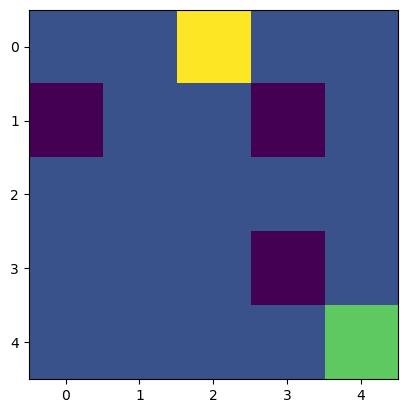

TimeStep no.: 49 , State: [0 2] , Action: 0 , Reward: -0.5 , Cumulative Reward: -120.0


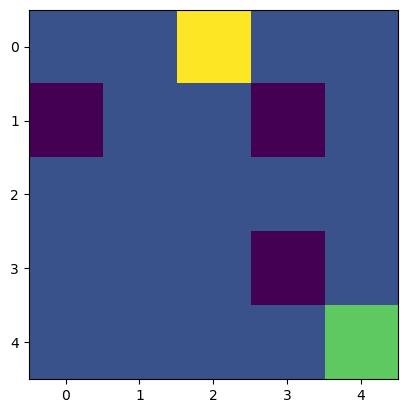

TimeStep no.: 50 , State: [0 2] , Action: 0 , Reward: -0.5 , Cumulative Reward: -120.5


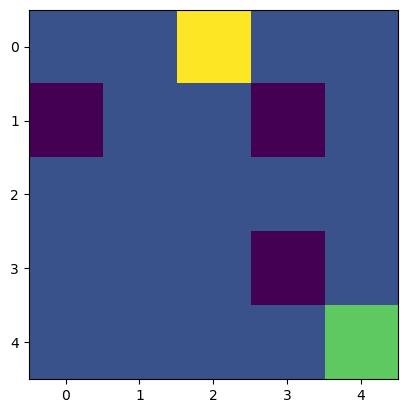

TimeStep no.: 51 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -121.0


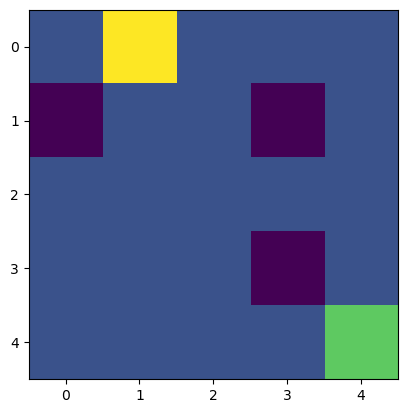

TimeStep no.: 52 , State: [1 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -121.5


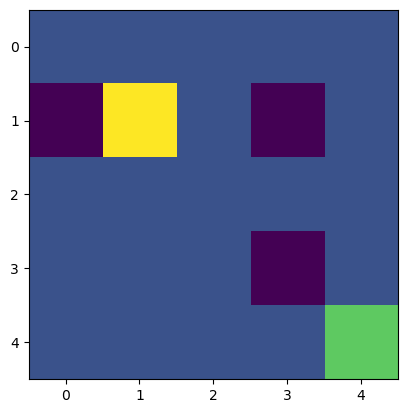

TimeStep no.: 53 , State: [1 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -122.0


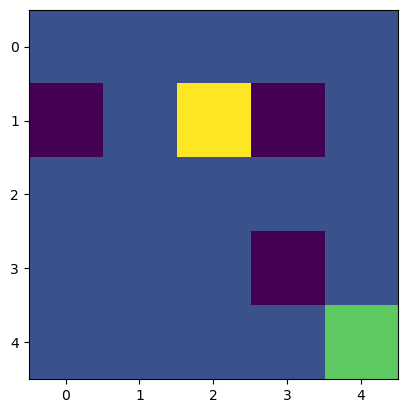

TimeStep no.: 54 , State: [1 3] , Action: 1 , Reward: -20 , Cumulative Reward: -142.0


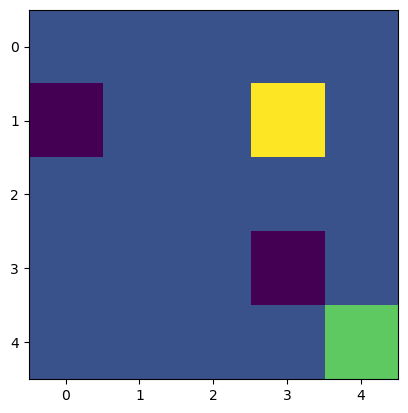

TimeStep no.: 55 , State: [1 2] , Action: 3 , Reward: -0.5 , Cumulative Reward: -142.5


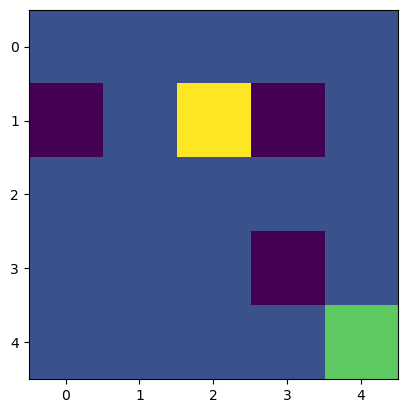

TimeStep no.: 56 , State: [1 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -143.0


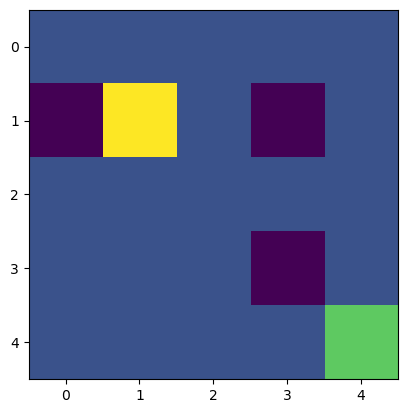

TimeStep no.: 57 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -143.5


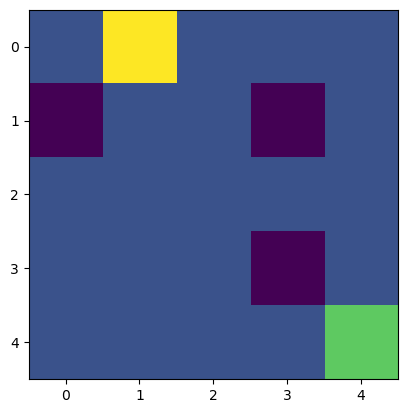

TimeStep no.: 58 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -144.0


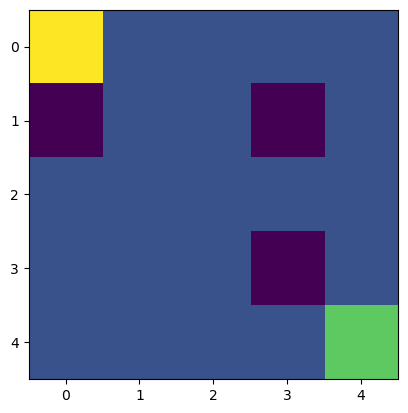

TimeStep no.: 59 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -144.5


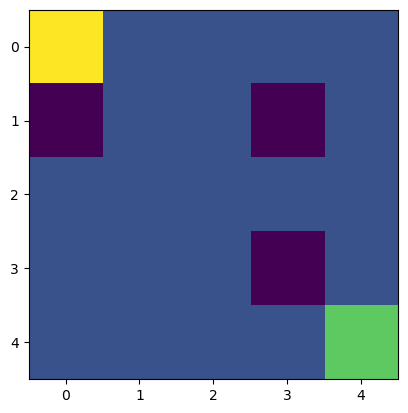

TimeStep no.: 60 , State: [1 0] , Action: 2 , Reward: -20 , Cumulative Reward: -164.5


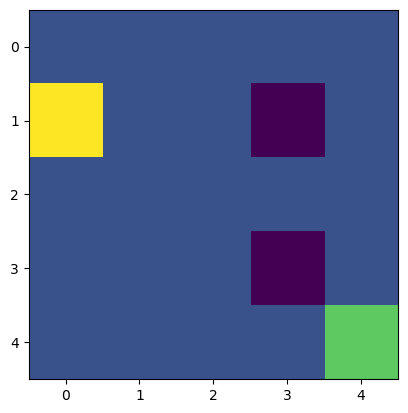

TimeStep no.: 61 , State: [2 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -165.0


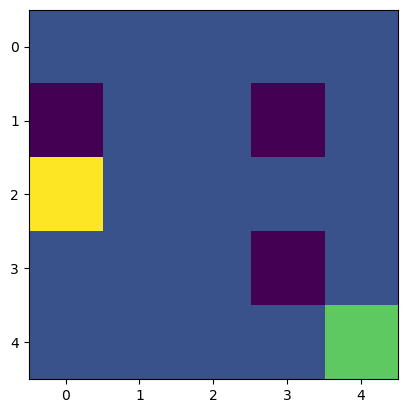

TimeStep no.: 62 , State: [3 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -165.5


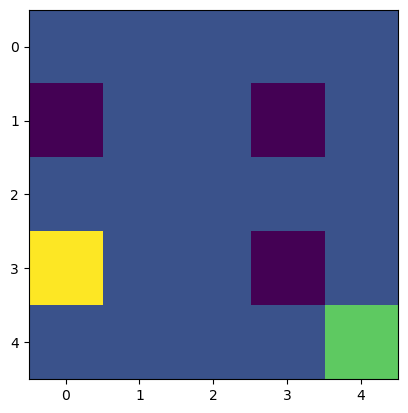

TimeStep no.: 63 , State: [2 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -166.0


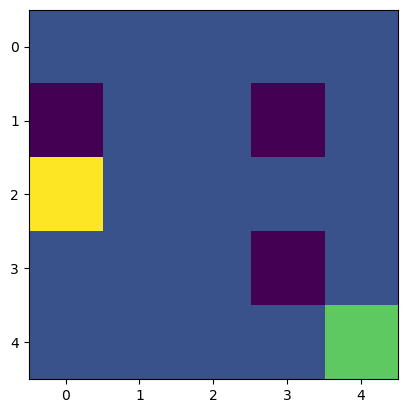

TimeStep no.: 64 , State: [3 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -166.5


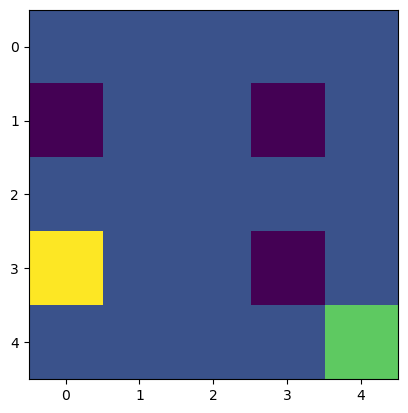

TimeStep no.: 65 , State: [2 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -167.0


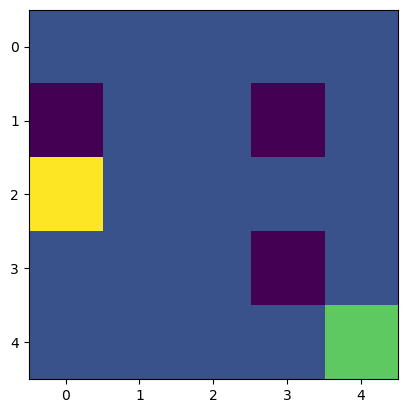

TimeStep no.: 66 , State: [1 0] , Action: 0 , Reward: -20 , Cumulative Reward: -187.0


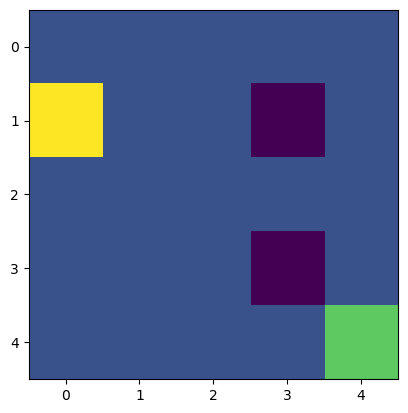

TimeStep no.: 67 , State: [1 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -187.5


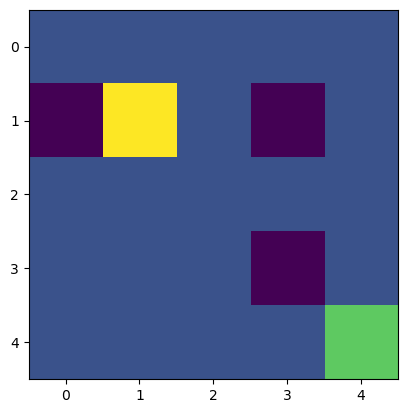

TimeStep no.: 68 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -207.5


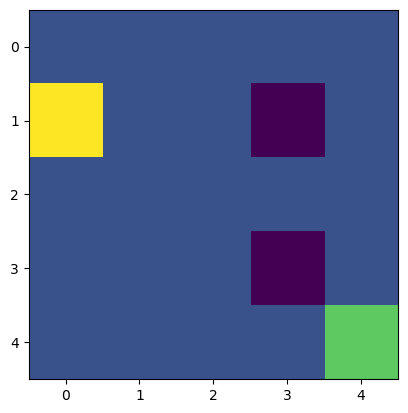

TimeStep no.: 69 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -227.5


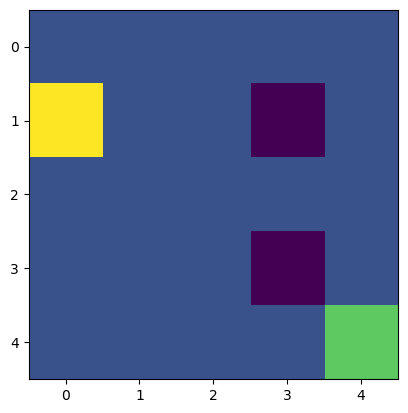

TimeStep no.: 70 , State: [2 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -228.0


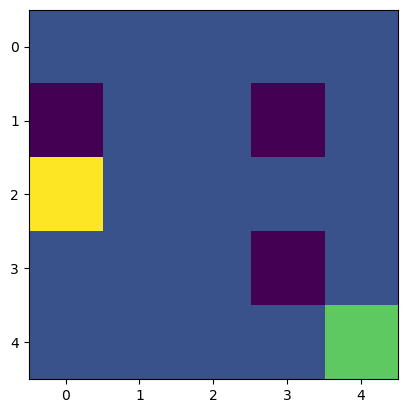

TimeStep no.: 71 , State: [1 0] , Action: 0 , Reward: -20 , Cumulative Reward: -248.0


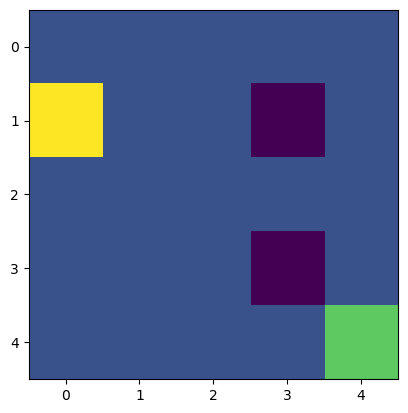

TimeStep no.: 72 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -248.5


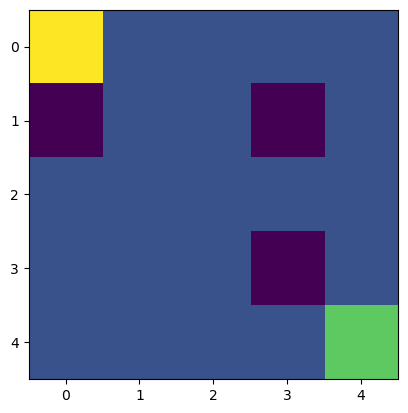

TimeStep no.: 73 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -249.0


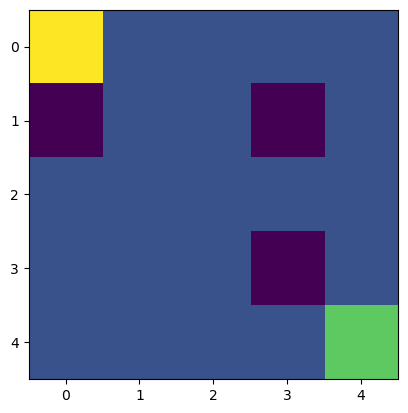

TimeStep no.: 74 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -249.5


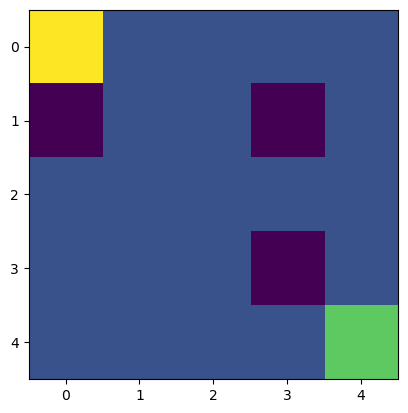

TimeStep no.: 75 , State: [1 0] , Action: 2 , Reward: -20 , Cumulative Reward: -269.5


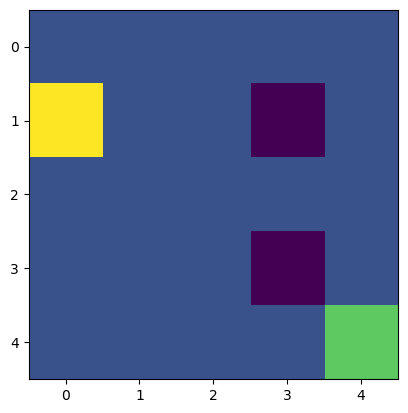

TimeStep no.: 76 , State: [1 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -270.0


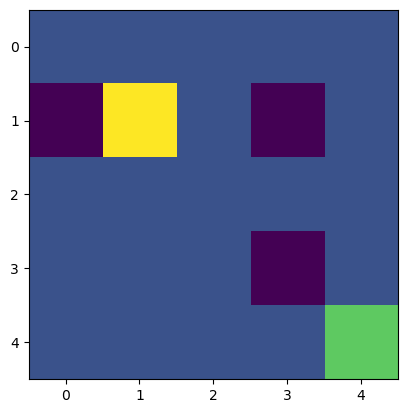

TimeStep no.: 77 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -270.5


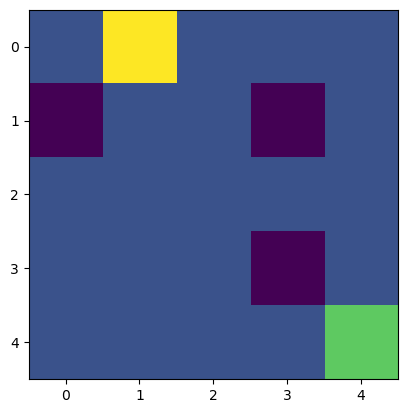

TimeStep no.: 78 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -271.0


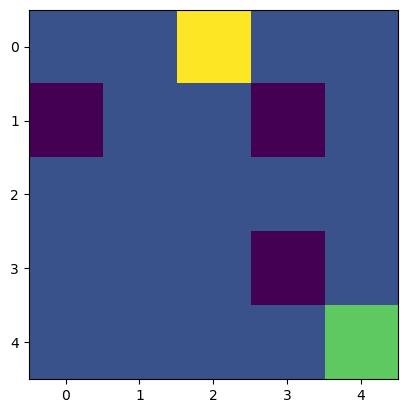

TimeStep no.: 79 , State: [1 2] , Action: 2 , Reward: -0.5 , Cumulative Reward: -271.5


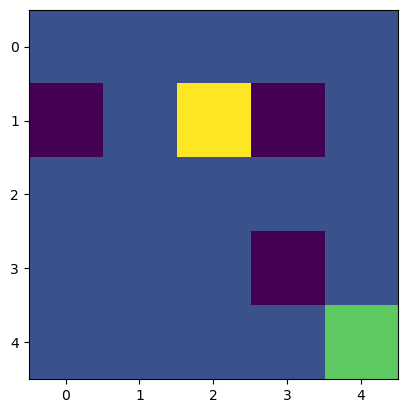

TimeStep no.: 80 , State: [1 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -272.0


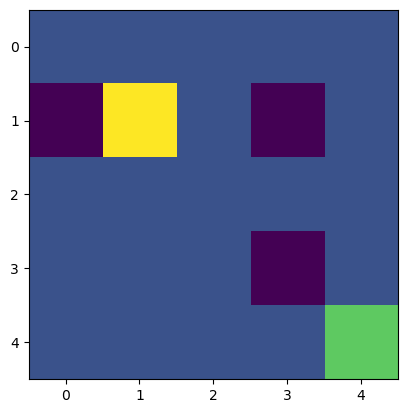

TimeStep no.: 81 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -272.5


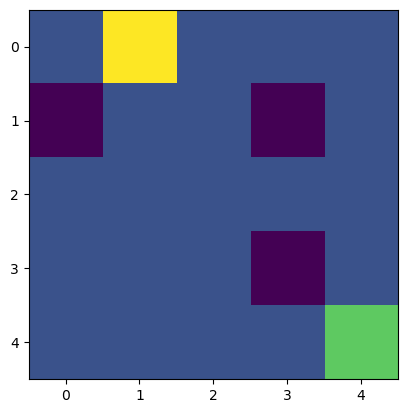

TimeStep no.: 82 , State: [1 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -273.0


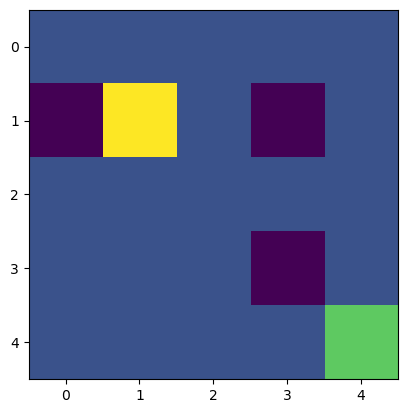

TimeStep no.: 83 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -273.5


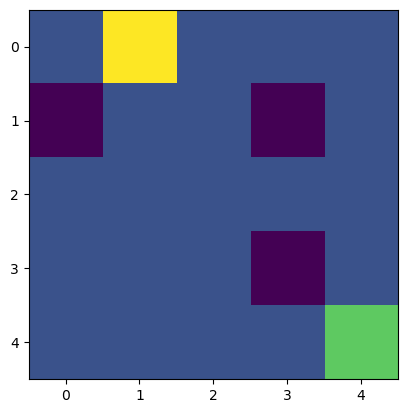

TimeStep no.: 84 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -274.0


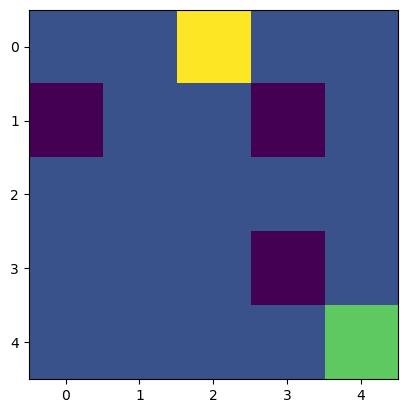

TimeStep no.: 85 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -274.5


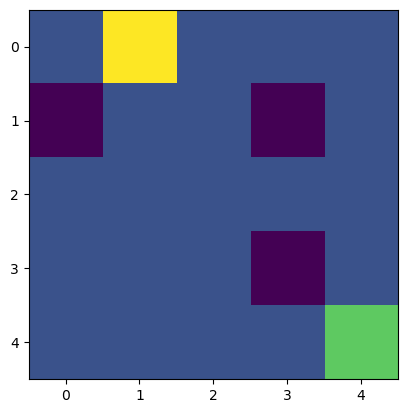

TimeStep no.: 86 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -275.0


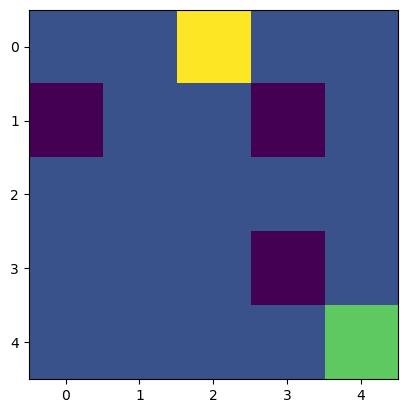

TimeStep no.: 87 , State: [0 2] , Action: 0 , Reward: -0.5 , Cumulative Reward: -275.5


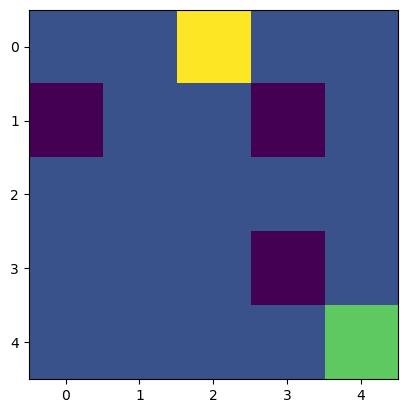

TimeStep no.: 88 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -276.0


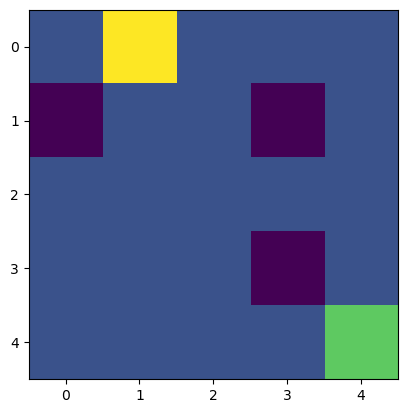

TimeStep no.: 89 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -276.5


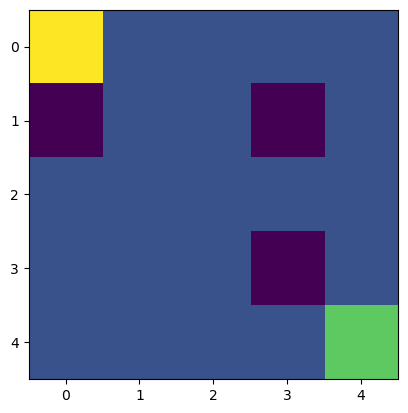

TimeStep no.: 90 , State: [0 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -277.0


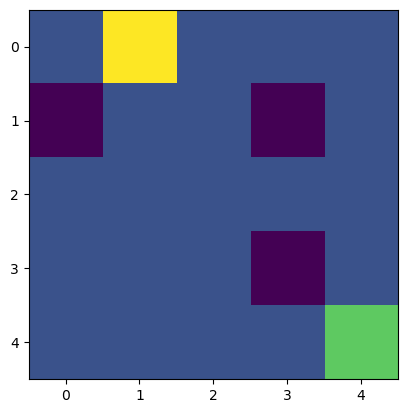

TimeStep no.: 91 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -277.5


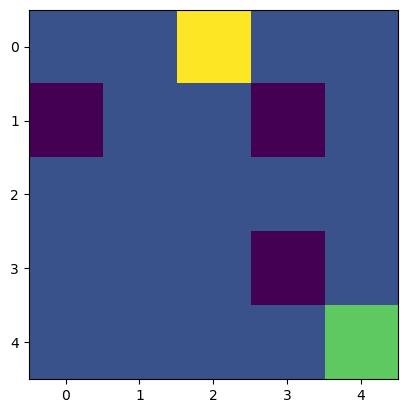

TimeStep no.: 92 , State: [0 3] , Action: 1 , Reward: -0.5 , Cumulative Reward: -278.0


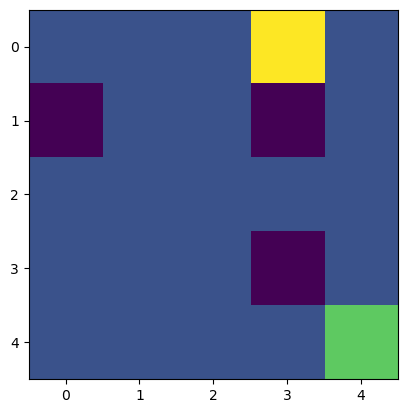

TimeStep no.: 93 , State: [0 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -278.5


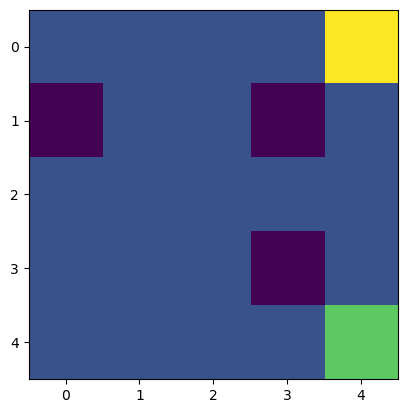

TimeStep no.: 94 , State: [1 4] , Action: 2 , Reward: -0.5 , Cumulative Reward: -279.0


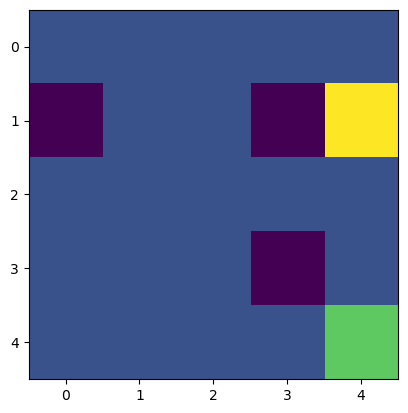

TimeStep no.: 95 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -279.5


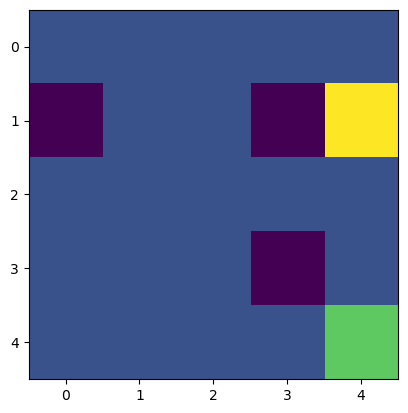

TimeStep no.: 96 , State: [0 4] , Action: 0 , Reward: -0.5 , Cumulative Reward: -280.0


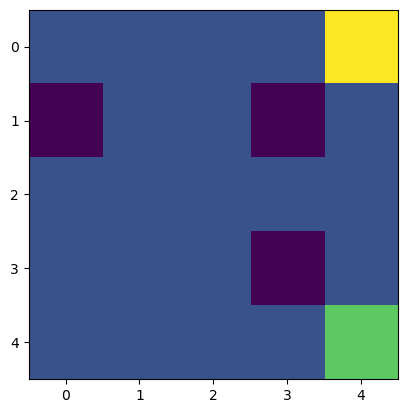

TimeStep no.: 97 , State: [0 4] , Action: 0 , Reward: -0.5 , Cumulative Reward: -280.5


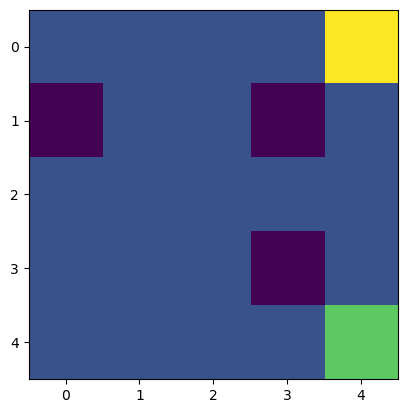

TimeStep no.: 98 , State: [1 4] , Action: 2 , Reward: -0.5 , Cumulative Reward: -281.0


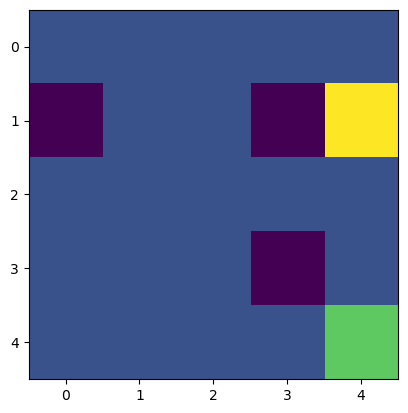

TimeStep no.: 99 , State: [2 4] , Action: 2 , Reward: -0.5 , Cumulative Reward: -281.5


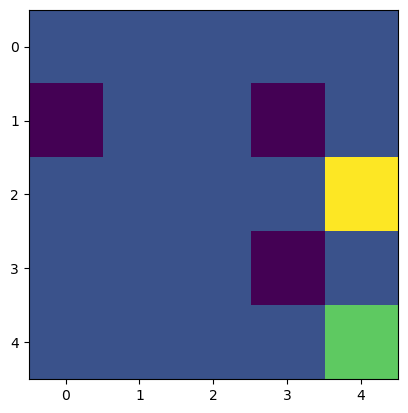

TimeStep no.: 100 , State: [2 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -282.0


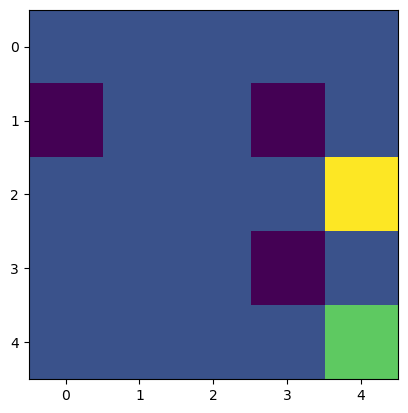

TimeStep no.: 101 , State: [2 3] , Action: 3 , Reward: -0.5 , Cumulative Reward: -282.5


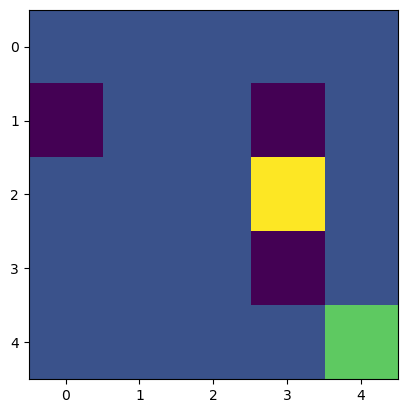

TimeStep no.: 102 , State: [1 3] , Action: 0 , Reward: -20 , Cumulative Reward: -302.5


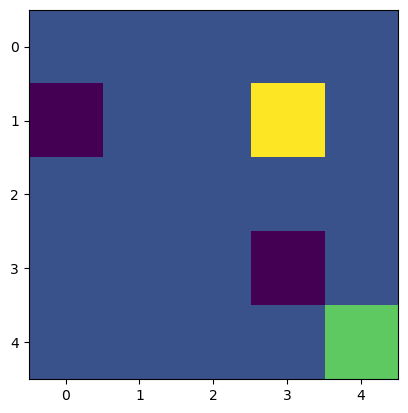

TimeStep no.: 103 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -303.0


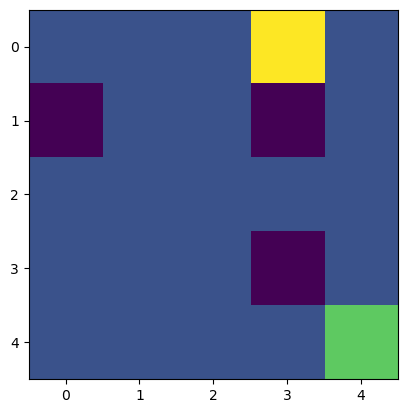

TimeStep no.: 104 , State: [0 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -303.5


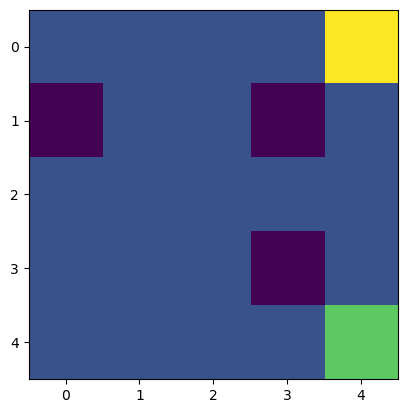

TimeStep no.: 105 , State: [0 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -304.0


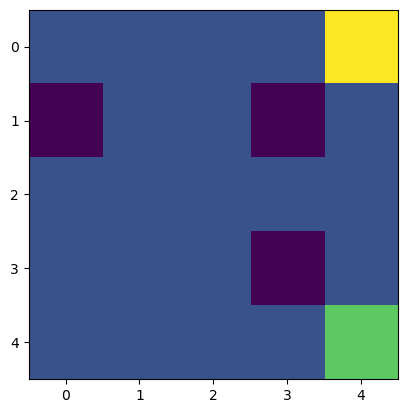

TimeStep no.: 106 , State: [0 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -304.5


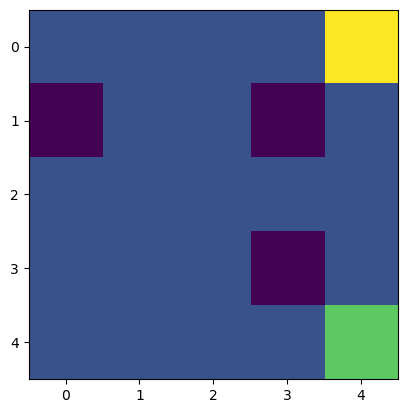

TimeStep no.: 107 , State: [1 4] , Action: 2 , Reward: -0.5 , Cumulative Reward: -305.0


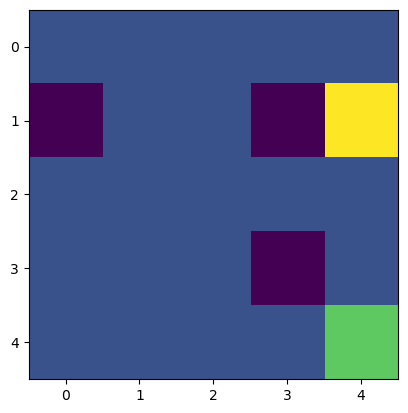

TimeStep no.: 108 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -305.5


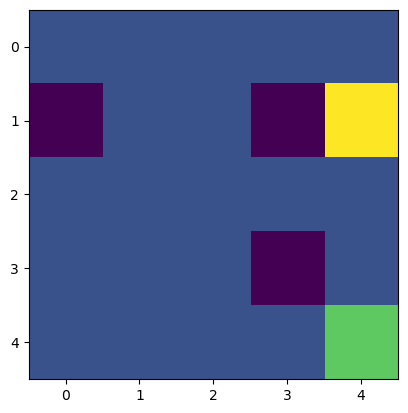

TimeStep no.: 109 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -306.0


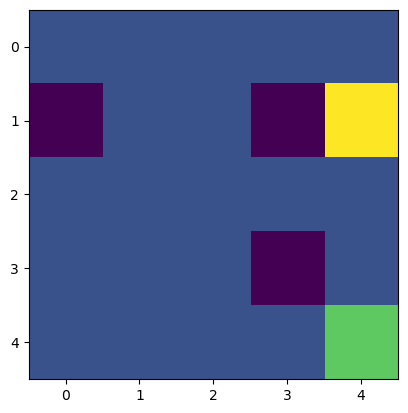

TimeStep no.: 110 , State: [1 3] , Action: 3 , Reward: -20 , Cumulative Reward: -326.0


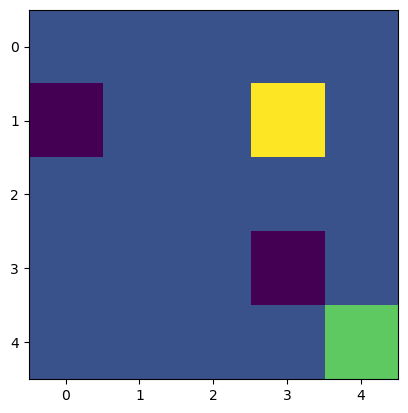

TimeStep no.: 111 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -326.5


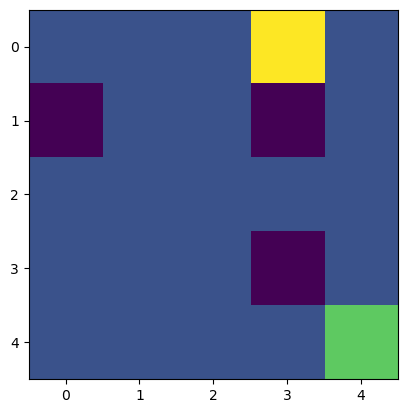

TimeStep no.: 112 , State: [1 3] , Action: 2 , Reward: -20 , Cumulative Reward: -346.5


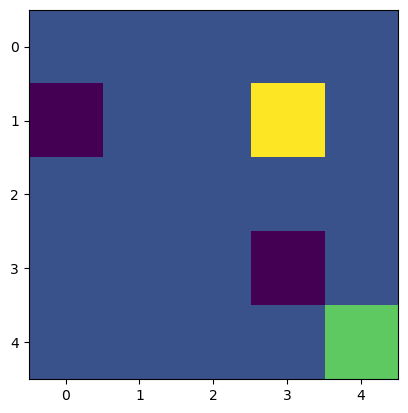

TimeStep no.: 113 , State: [2 3] , Action: 2 , Reward: -0.5 , Cumulative Reward: -347.0


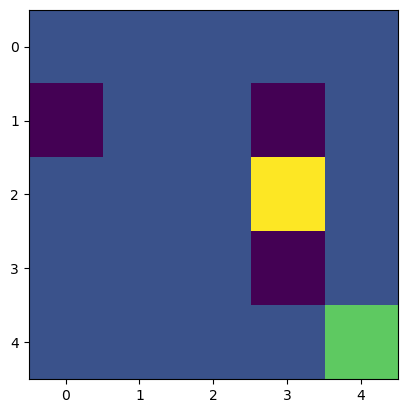

TimeStep no.: 114 , State: [1 3] , Action: 0 , Reward: -20 , Cumulative Reward: -367.0


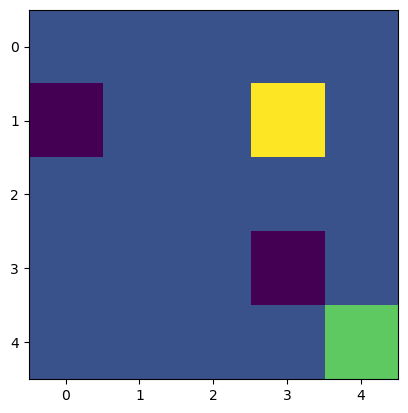

TimeStep no.: 115 , State: [1 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -367.5


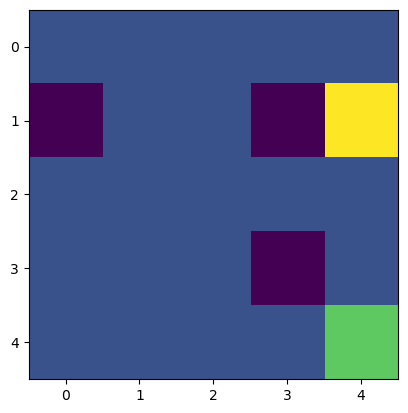

TimeStep no.: 116 , State: [1 3] , Action: 3 , Reward: -20 , Cumulative Reward: -387.5


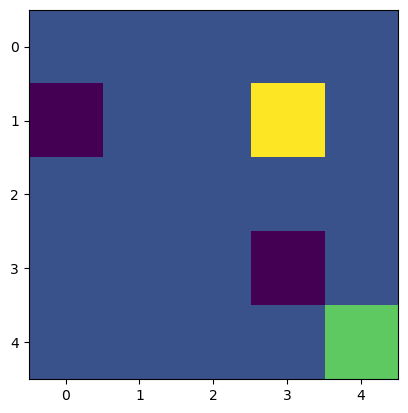

TimeStep no.: 117 , State: [0 3] , Action: 0 , Reward: -0.5 , Cumulative Reward: -388.0


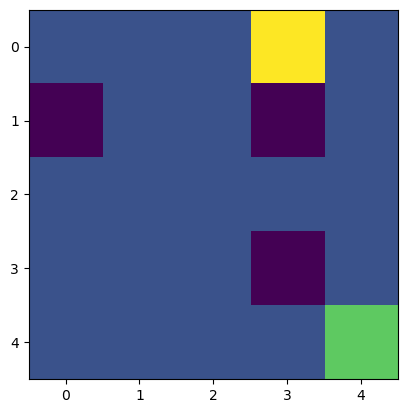

TimeStep no.: 118 , State: [1 3] , Action: 2 , Reward: -20 , Cumulative Reward: -408.0


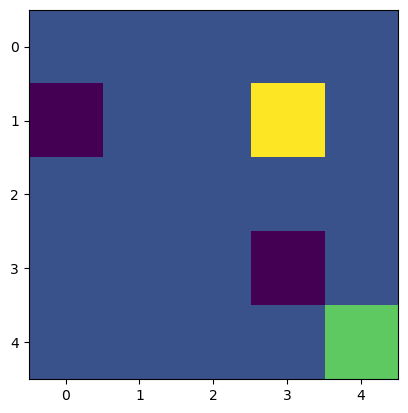

TimeStep no.: 119 , State: [1 2] , Action: 3 , Reward: -0.5 , Cumulative Reward: -408.5


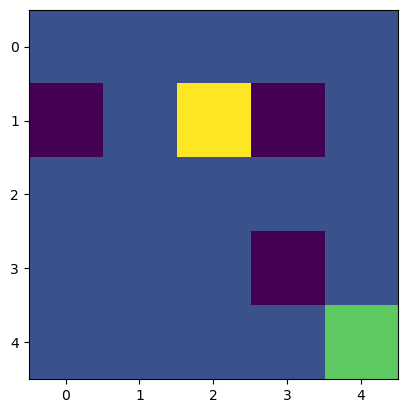

TimeStep no.: 120 , State: [1 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -409.0


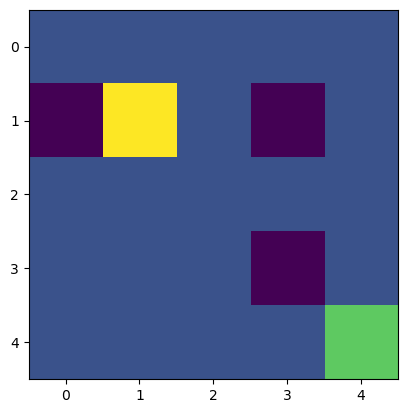

TimeStep no.: 121 , State: [2 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -409.5


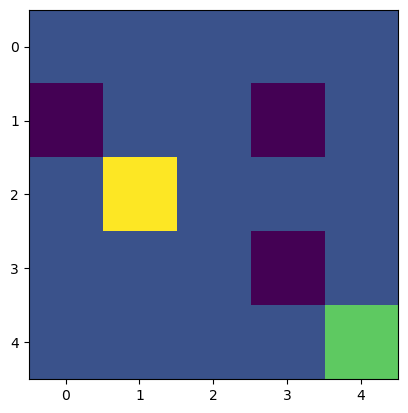

TimeStep no.: 122 , State: [2 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -410.0


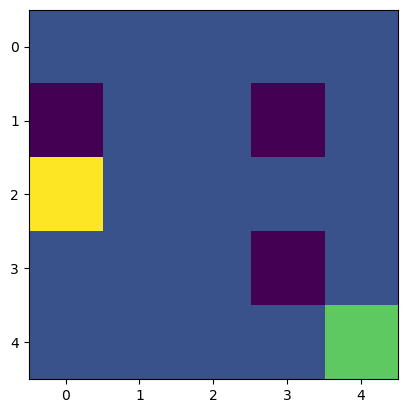

TimeStep no.: 123 , State: [3 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -410.5


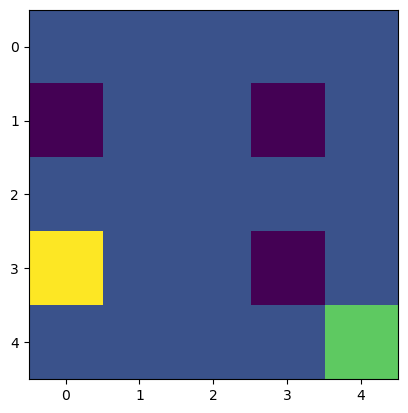

TimeStep no.: 124 , State: [2 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -411.0


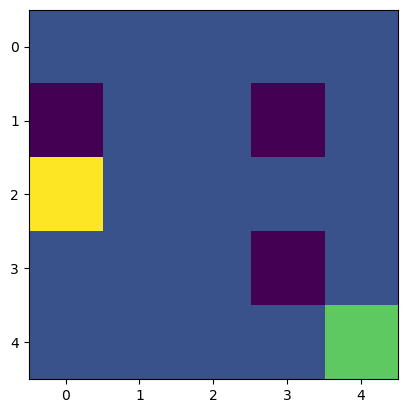

TimeStep no.: 125 , State: [1 0] , Action: 0 , Reward: -20 , Cumulative Reward: -431.0


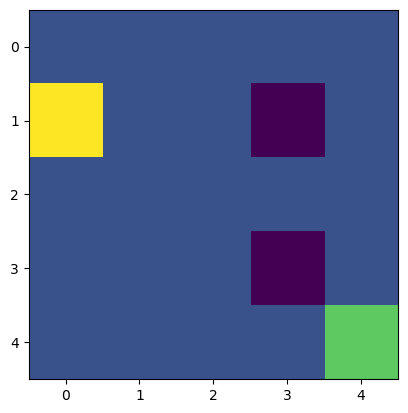

TimeStep no.: 126 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -451.0


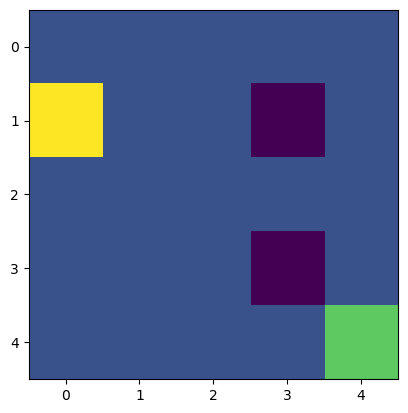

TimeStep no.: 127 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -471.0


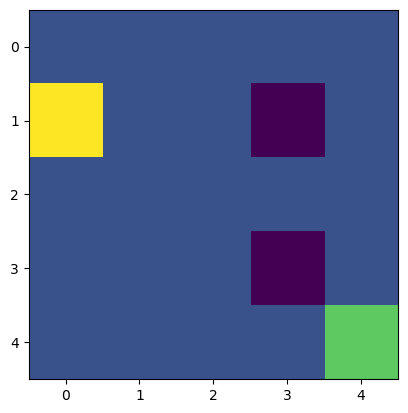

TimeStep no.: 128 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -491.0


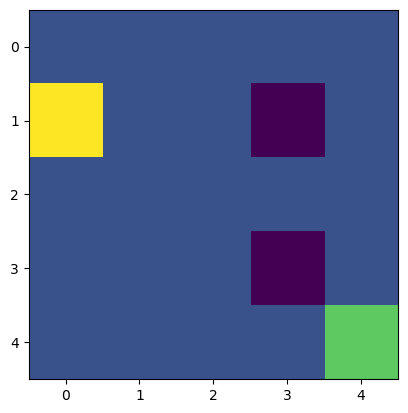

TimeStep no.: 129 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -491.5


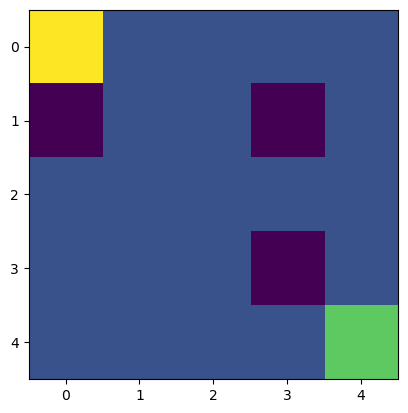

TimeStep no.: 130 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -492.0


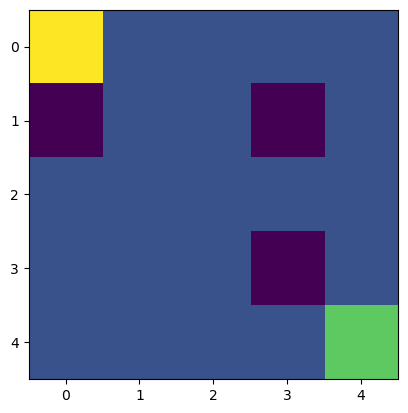

TimeStep no.: 131 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -492.5


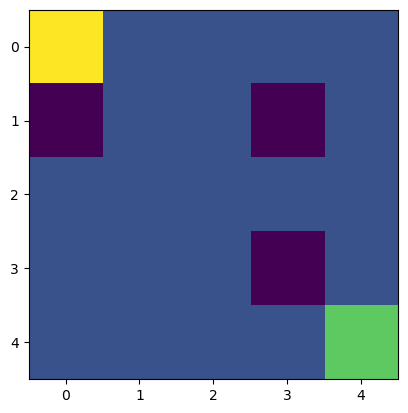

TimeStep no.: 132 , State: [0 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -493.0


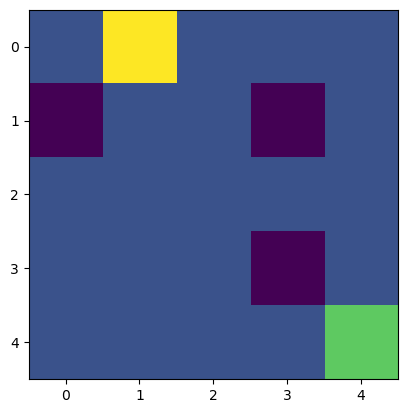

TimeStep no.: 133 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -493.5


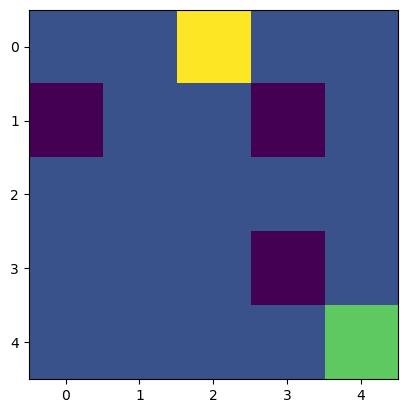

TimeStep no.: 134 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -494.0


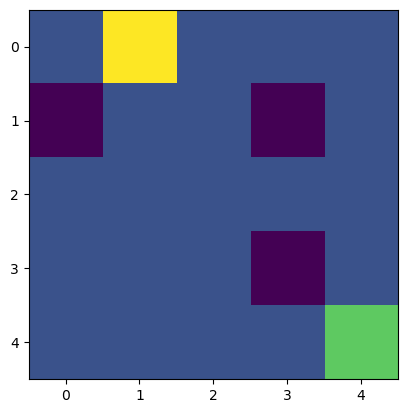

TimeStep no.: 135 , State: [0 0] , Action: 3 , Reward: -0.5 , Cumulative Reward: -494.5


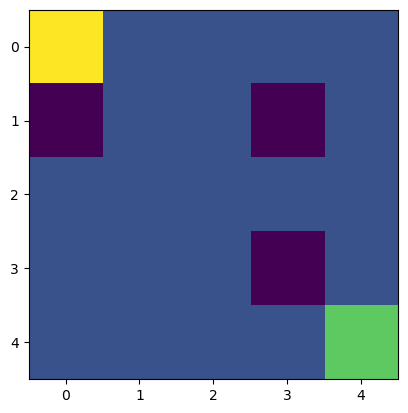

TimeStep no.: 136 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -495.0


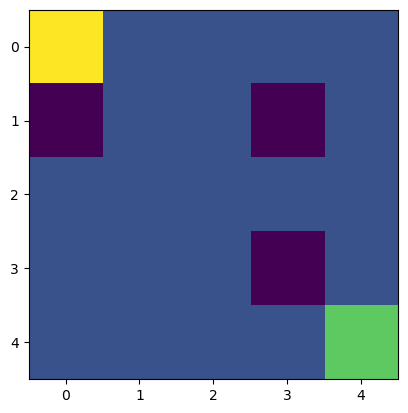

TimeStep no.: 137 , State: [1 0] , Action: 2 , Reward: -20 , Cumulative Reward: -515.0


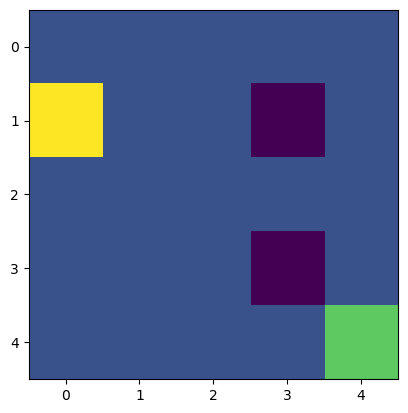

TimeStep no.: 138 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -535.0


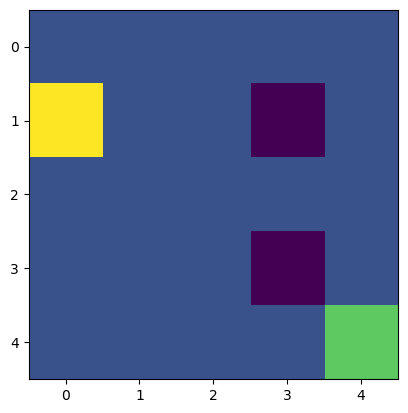

TimeStep no.: 139 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -535.5


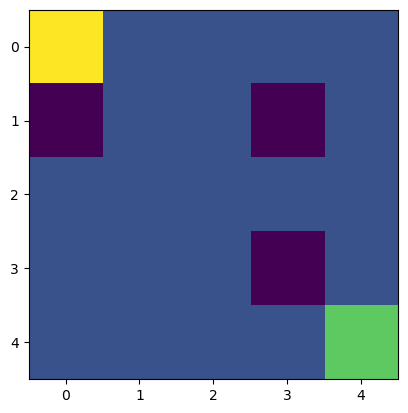

TimeStep no.: 140 , State: [0 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -536.0


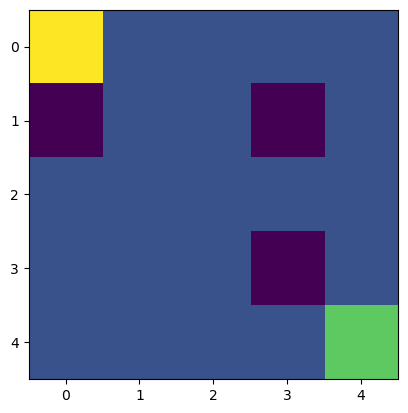

TimeStep no.: 141 , State: [1 0] , Action: 2 , Reward: -20 , Cumulative Reward: -556.0


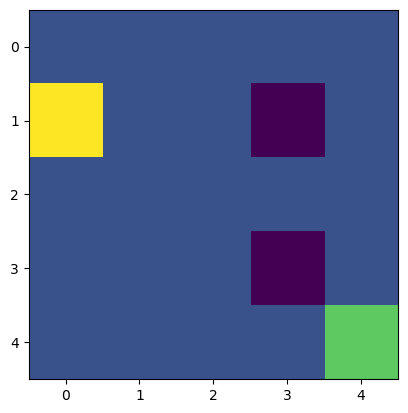

TimeStep no.: 142 , State: [2 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -556.5


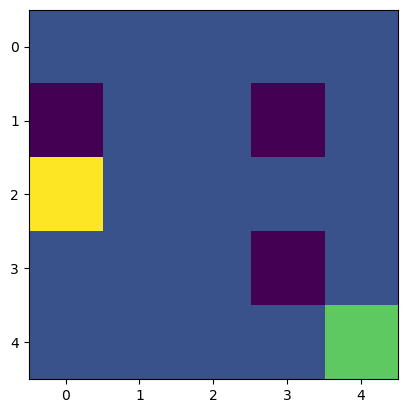

TimeStep no.: 143 , State: [2 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -557.0


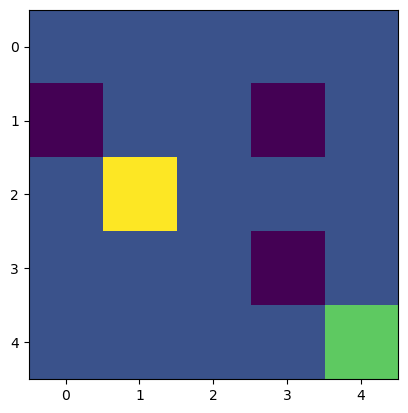

TimeStep no.: 144 , State: [3 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -557.5


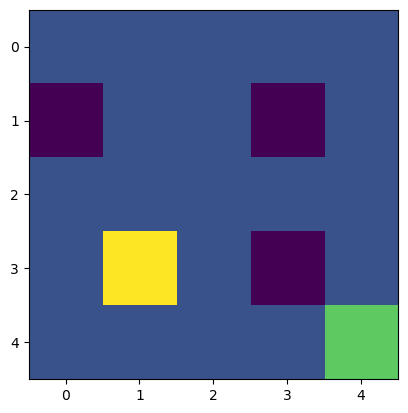

TimeStep no.: 145 , State: [3 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -558.0


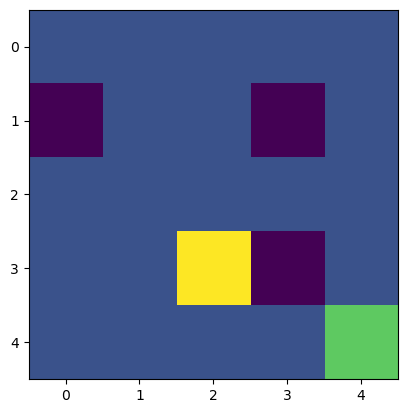

TimeStep no.: 146 , State: [3 3] , Action: 1 , Reward: -20 , Cumulative Reward: -578.0


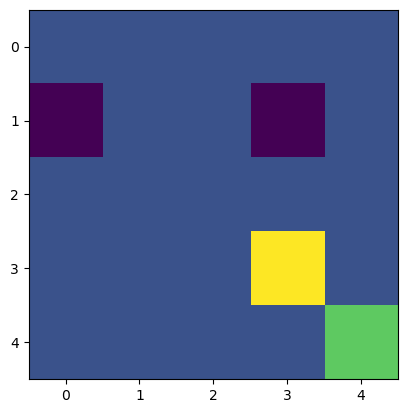

TimeStep no.: 147 , State: [3 4] , Action: 1 , Reward: -0.5 , Cumulative Reward: -578.5


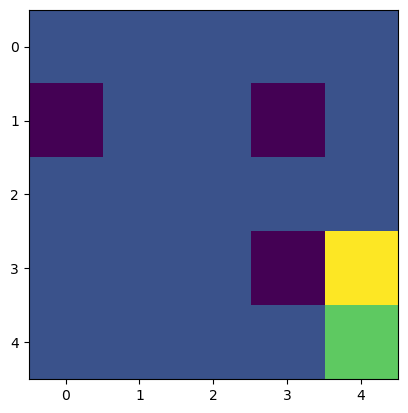

TimeStep no.: 148 , State: [4 4] , Action: 2 , Reward: 100 , Cumulative Reward: -478.5


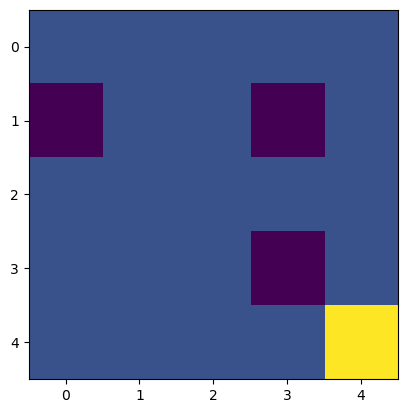

Final Cumulative Reward: -478.5


In [7]:
# Run till the agent reaches the goal
env = TreasureHuntEnv(max_timesteps=0)
state = env.reset()
env.render()

terminated, truncated, i = False, False, 1
while not terminated and not truncated:
    action = env.action_space.sample()
    state, reward, terminated, truncated, observation, info = env.step(action)
    print("TimeStep no.:",i,", State:",state,", Action:",action,", Reward:",reward,", Cumulative Reward:",env.cumulative_reward)
    env.render()
    i += 1

print(f"Final Cumulative Reward: {env.cumulative_reward}")

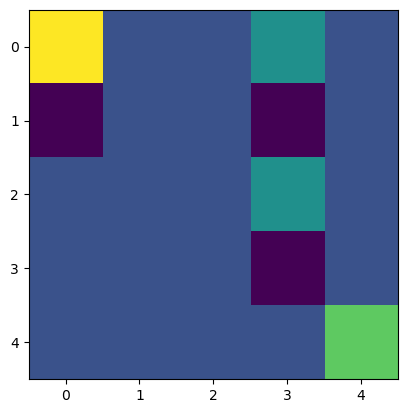

TimeStep no.: 1 , State: [0 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -0.5


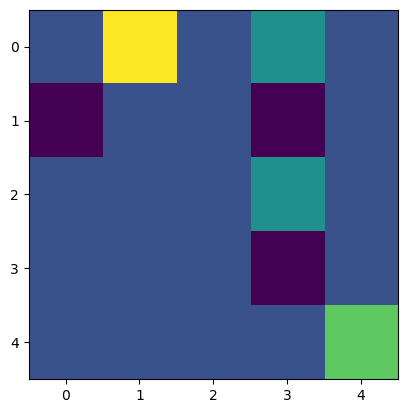

TimeStep no.: 2 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -1.0


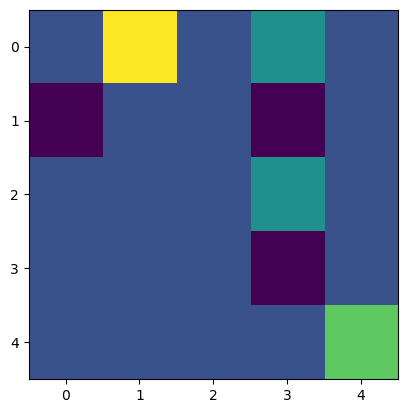

TimeStep no.: 3 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -1.5


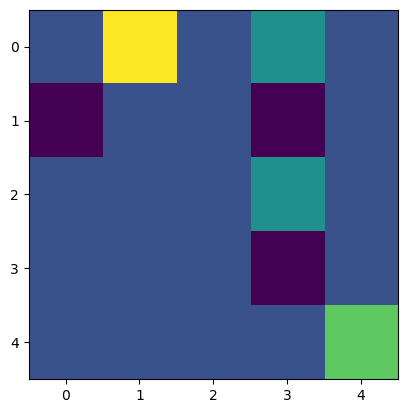

TimeStep no.: 4 , State: [0 1] , Action: 0 , Reward: -0.5 , Cumulative Reward: -2.0


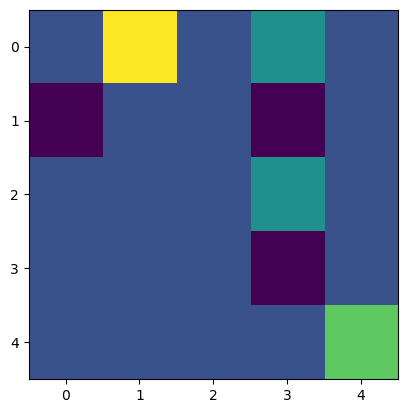

TimeStep no.: 5 , State: [0 2] , Action: 1 , Reward: -0.5 , Cumulative Reward: -2.5


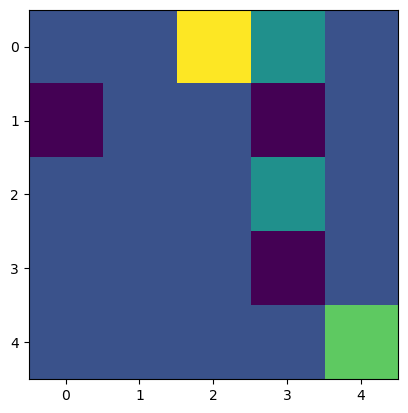

TimeStep no.: 6 , State: [0 2] , Action: 0 , Reward: -0.5 , Cumulative Reward: -3.0


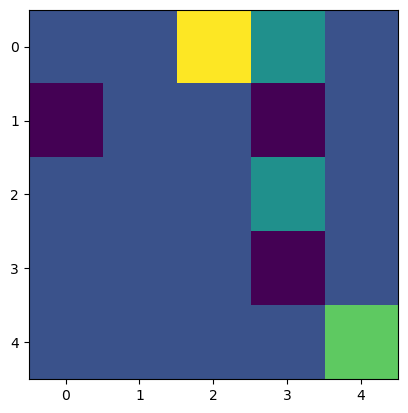

TimeStep no.: 7 , State: [0 1] , Action: 3 , Reward: -0.5 , Cumulative Reward: -3.5


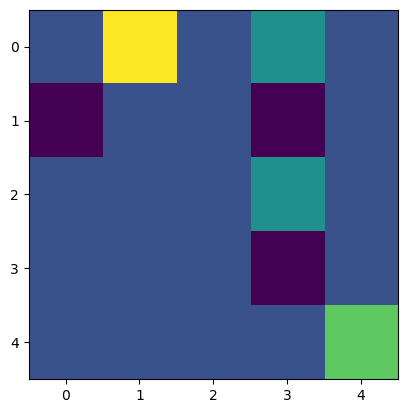

TimeStep no.: 8 , State: [1 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -4.0


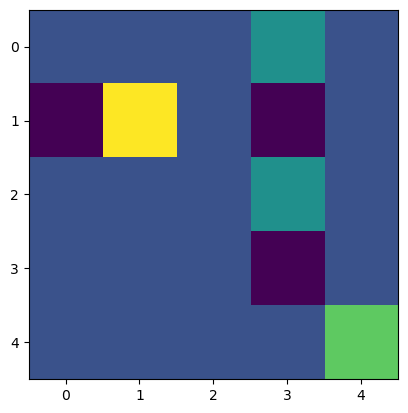

TimeStep no.: 9 , State: [1 0] , Action: 3 , Reward: -20 , Cumulative Reward: -24.0


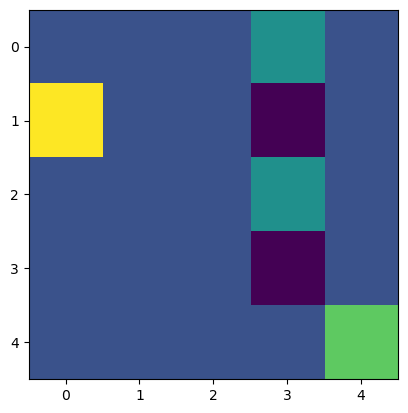

TimeStep no.: 10 , State: [2 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -24.5


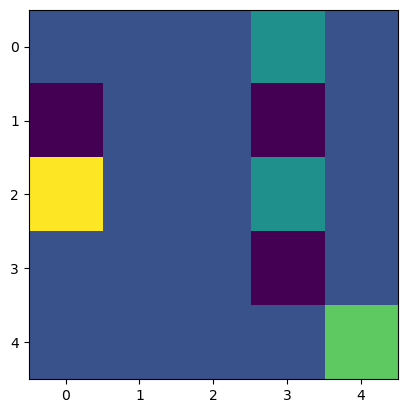

TimeStep no.: 11 , State: [3 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -25.0


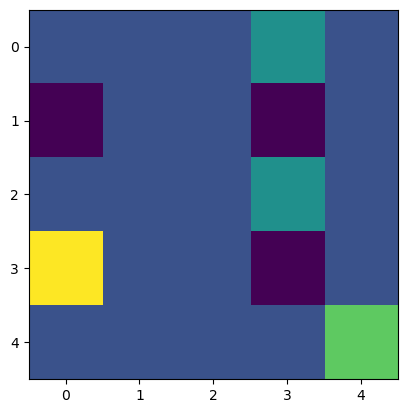

TimeStep no.: 12 , State: [4 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -25.5


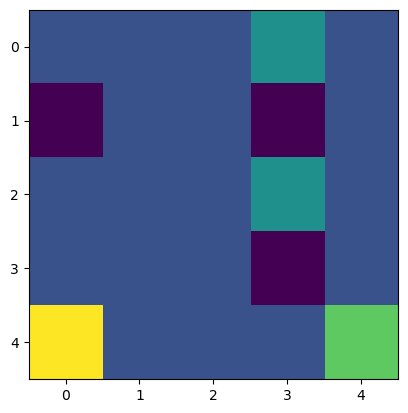

TimeStep no.: 13 , State: [4 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -26.0


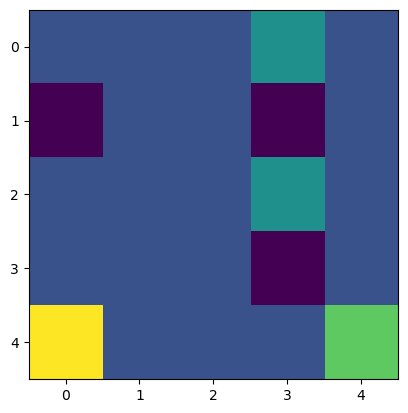

TimeStep no.: 14 , State: [4 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -26.5


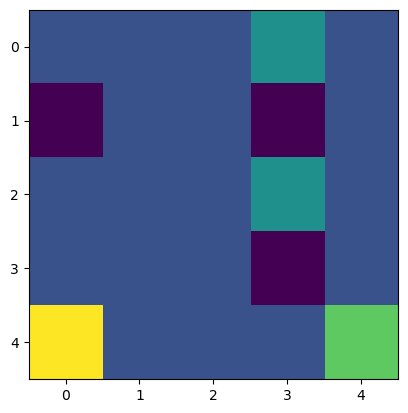

TimeStep no.: 15 , State: [3 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -27.0


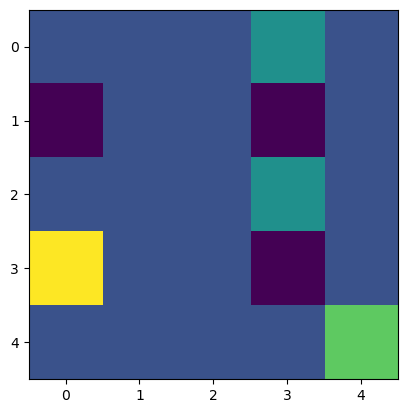

TimeStep no.: 16 , State: [4 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -27.5


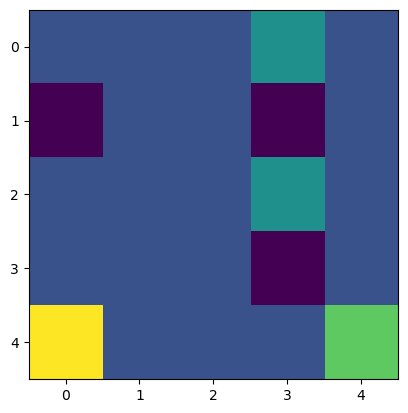

TimeStep no.: 17 , State: [3 0] , Action: 0 , Reward: -0.5 , Cumulative Reward: -28.0


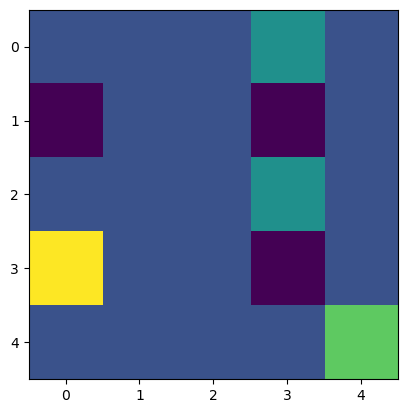

TimeStep no.: 18 , State: [4 0] , Action: 2 , Reward: -0.5 , Cumulative Reward: -28.5


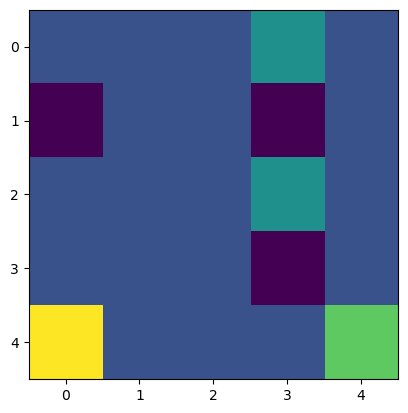

TimeStep no.: 19 , State: [4 1] , Action: 1 , Reward: -0.5 , Cumulative Reward: -29.0


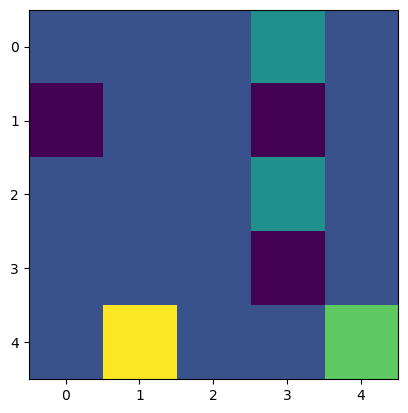

TimeStep no.: 20 , State: [4 1] , Action: 2 , Reward: -0.5 , Cumulative Reward: -29.5


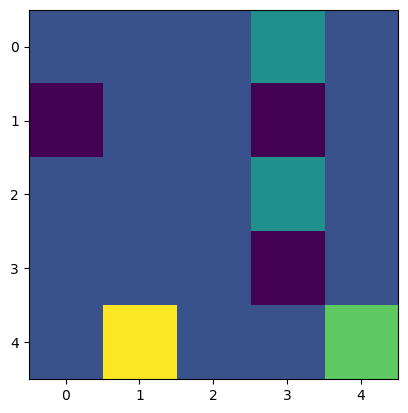

Final Cumulative Reward: -29.5


In [6]:
# Run for a fixed number of timesteps
env = TreasureHuntEnv(max_timesteps=20)
state = env.reset()
env.render()

terminated, truncated, i = False, False, 1
while not terminated and not truncated:
    action = env.action_space.sample()
    state, reward, terminated, truncated, observation, info = env.step(action)
    print("TimeStep no.:",i,", State:",state,", Action:",action,", Reward:",reward,", Cumulative Reward:",env.cumulative_reward)
    env.render()
    i += 1

print(f"Final Cumulative Reward: {env.cumulative_reward}")